In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn import preprocessing
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error

In [2]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
path = '../../../Resources/'
test_df = pd.read_csv(path + 'test.csv')
building_meta_df = pd.read_csv(path + 'building_metadata.csv')

In [4]:
leak_df = pd.read_feather('../../../Large_output/leaking/leak.feather')
leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

In [5]:
# cat_clean, lgb3_clean, lgb3_clean, no_0, nn_clean+xgb_clean
sub_path = '../../../Large_output/good_submission/'
sub_list = ['cat_1.074.csv', 'lgbm_site0_1.074.csv', 'lgb3_1.081.csv', 'lgb3_1.082.csv', 'xgb_new_noM_1.084.csv', 
            'nn_clean_1.100.csv']
sample_submission1 = pd.read_csv(sub_path + sub_list[0], index_col=0)
sample_submission2 = pd.read_csv(sub_path + sub_list[1], index_col=0)
sample_submission3 = pd.read_csv(sub_path + sub_list[2], index_col=0)
sample_submission4 = pd.read_csv(sub_path + sub_list[3], index_col=0)
sample_submission5 = pd.read_csv(sub_path + sub_list[4], index_col=0)
sample_submission6 = pd.read_csv(sub_path + sub_list[5], index_col=0)

/local/home/ningzesun/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
test_df['pred1'] = sample_submission1.meter_reading
test_df['pred2'] = sample_submission2.meter_reading
test_df['pred3'] = sample_submission3.meter_reading
test_df['pred4'] = sample_submission4.meter_reading
test_df['pred5'] = sample_submission5.meter_reading
test_df['pred6'] = sample_submission6.meter_reading

del  sample_submission1,  sample_submission2,  sample_submission3,sample_submission4,sample_submission5,sample_submission6
gc.collect()

0

In [7]:
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
leak_df["timestamp"] = pd.to_datetime(leak_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [8]:
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred1',\
                                 'pred2', 'pred3','pred4','pred5','pred6',\
                                 'row_id']], on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')

In [9]:
leak_df['meter_reading_l1p'] = np.log1p(leak_df.meter_reading)

In [13]:
from sko.PSO import PSO
from sko.GA import GA
# Define the genetic algorithm function
def optimization(p):
    w1,w2,w3,w4,w5,w6 = p
    v = w1 * leak_df['pred1'].values + w2 * leak_df['pred2'].values + w3 * leak_df['pred3'] +\
    w4 * leak_df['pred4'].values + w5 * leak_df['pred5'].values + w6 * leak_df['pred6']
    vl1p = np.log1p(v)
    print(np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p)))
    return np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

In [15]:
from sko.PSO import PSO
pso = PSO(func=optimization, dim=6, pop=200, max_iter=300, lb=[0,0,0,0,0,0],ub=[0.5,0.5,0.5,0.5,0.5,0.5], w=0.8, c1=0.5, c2=0.5)
pso.run()
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

1.097465605900632
0.9615568497437134
0.9916207022946549
1.1255600664756877
1.063052142391027
1.26136665813397
1.2508623372853203
1.1692900469459644
1.0014272644311724
1.0190546792825508
1.0487079184888775
0.9721248389366882
1.0107427780317848
1.2214904558751083
1.2076790894326006
1.1836314543083735
0.9697427829570379
1.1242435695279662
1.0068564244717702
1.1335800911645295
1.0871310021458467
1.154386569743471
1.1424315441724582
1.1779458700165064
0.98063922184206
1.0834300416444265
1.1478181466506183
1.1226991546561709
1.0813743300050664
1.1337085721045963
1.1123731459277857
1.095291071326652
1.0448363532755618
0.9929489607118778
0.9890768221015613
1.1008586398672164
1.299714184353284
1.225699467297203
1.0242954935885538
1.0556038161529693
1.0363958394558117
1.241542270312779
1.0317037092317811
1.0904565816439507
1.0519553027589503
1.385470370172441
1.1320449880428056
1.0491485673104262
1.052734727010635
1.3324766929058507
1.2222444439155649
0.9744106979731881
0.9687649221214701
1.1166

1.0916439088384593
0.9618309051984065
1.007234948807489
1.1018530891769067
1.0506563085816398
1.5687302231553442
1.0445755288022414
0.9964949638655739
1.2043315629244604
1.2331242615400375
1.1039541147782734
1.040065053265028
1.1065195068667217
1.0889914020437568
1.0333316913710362
0.9940415841409254
1.0632884425636768
1.1556414064247398
1.1063931336698367
1.2292812701710472
1.1855480054400644
1.0943794572863055
2.016658540382187
0.9901081726061164
1.0978413490746919
1.13312970907775
1.0420810051099745
1.073679582692969
1.211508019610901
0.9679368910113539
1.113326895482164
0.9643681182195569
1.2301135774666518
1.2139617531618825
1.05995276456261
1.0760720932053607
1.0010031105274697
1.1464333804682976
1.2541120966696415
1.114924163919916
0.9846574730862009
0.975494842969224
1.0192456985905327
1.2202548577336552
1.093428966704462
1.0070248577904728
1.1256859576096194
1.2740325601231153
1.0113515421061106
0.9856629274982142
1.1680280506723517
1.1944773658414194
1.060821539857586
0.96527

0.9668723986726984
1.0182203522888715
1.0584379542786602
0.9572136875833015
0.9695823140519343
0.9762531553008358
0.9716750663752851
0.9928499608936079
0.9972114296679289
0.9875254737948211
0.9633975515292812
1.0079235496015357
0.9829838035285551
0.9756179632213433
1.0045992348352573
0.9607309935334133
0.9705228887800849
0.978006431444639
0.9569534112756851
1.066291529235232
1.0223465851491496
0.9812228777322188
0.9565179579283754
0.961906424199307
0.9594171776567177
0.9674968902444206
1.0831869092990056
0.9744706357234891
1.0266101273937218
0.9623620829517162
0.9699650863600092
0.962093176072265
0.9720279592880268
0.9601321312126857
0.95632676211286
1.0486542731321369
1.0075424523675118
1.0594350411726536
1.0950106564028603
0.9602771937890667
1.009163027917468
0.9754047466577065
1.0027073475729575
0.9610854451685872
0.9639324869255786
1.1651004834357257
0.9642134653924599
1.0271303405786458
1.0455581337786775
0.9834429960563668
0.9643347381298255
0.9662944548209748
0.9862341021879119


1.034188017547217
0.9666445069342605
0.9798030998662108
0.9612534264743482
0.9616885665697031
0.9753681097552472
0.9928110126653598
0.9620669631495543
1.032729390903888
1.0077025439331022
0.9672713170819973
0.9910825063944111
0.9748300674494996
0.9774182220179258
0.9583820767783965
0.9584436206405709
0.9783713893999371
1.095938270739249
0.964161790280002
1.0214407950370148
1.008799918195431
1.072663605857784
0.9667179666697171
0.9773353546984436
0.9632767368782323
1.0130429963709593
1.325244388872789
0.9593800227498979
0.9629780330030692
0.9570123347037353
0.9766802983044367
0.989151080107641
0.957965991377849
0.9600989012510329
0.9728445091498832
0.98041126425107
0.9644246227074826
0.9604470004089507
0.9576918643889419
0.9587459686162468
0.9769085066888873
0.9568256302592051
0.9995082993383712
1.007736381619556
0.9697738684931293
0.9604175845884106
1.0952864075075583
0.9586887704294337
0.9694043053610814
0.9641423488582653
0.959507498025124
0.9676906165731747
0.960337157914316
0.96625

0.9590932796996956
0.9983439628869479
0.9578807959425935
0.9561624465497525
0.9584974372934162
0.9815981107617604
1.0004846477155636
0.984930175159798
0.9746339516372554
0.9765173693142102
1.0248089655384214
0.9562287673267486
0.9569934107068168
0.9750947836724891
0.9564387473497173
1.0171645909252716
0.960046695461332
0.9575423723893157
0.9560626031523379
0.9608124423106401
0.9621443452445543
1.0574707572923363
0.9932831505907269
1.042467584181733
0.9564210190114221
0.9564934716568098
0.9919698243171604
0.9744181469821387
0.9615630886749363
0.9610674656607161
1.020536402878794
1.0050999588370788
0.9657810616855984
0.956307027382915
0.9713583781585721
0.9663604415786406
0.9917726219052087
0.9811940023166145
0.9600458803329364
0.9579752163646683
0.9993198520885567
0.9584959996657493
0.9558177930722089
1.0049393091929133
1.0293182228195004
0.9616544648241901
0.9738298198487305
0.9769124851502321
0.9704534130388216
0.9637487578656442
0.9844416694647242
1.0089095304420708
1.026165385228554

0.9626636603563246
0.9684435207317004
0.9580467056867928
0.9682531081534641
0.9577859200950247
0.9578140479890878
0.9731069075661024
0.9549733176192412
0.9563514976961583
0.9596820354264297
0.9570611926842265
0.9737851450701569
0.960660717156518
0.9573186395715694
0.9613539249785147
0.9555500191706121
0.960952076068334
0.9560616369716521
0.9788014613904749
0.961252646747105
0.9737661266820395
0.95498208045378
1.0353550624470935
0.9563795061966441
0.9662468104621114
0.9567333509592729
0.955261470342864
0.9772842718573945
0.9570203850999993
0.9616940001813303
0.957515119531491
0.9591256296194127
0.9606026446430878
0.9631058939712442
0.9562513581717275
0.9851316894014714
0.9552927518597535
0.9586948799215962
0.9711579483703521
0.9576874939904454
0.9614230069313026
0.9641938574710885
0.9597622468194658
0.9727194058229871
0.9588842957938899
0.9573142435383695
0.959682785658379
0.9601831785194995
0.9554478600603138
0.9562244686445496
0.9611847964778547
0.955352825157282
0.9658268811752441
0.

1.0410613249228768
0.9607845341516845
0.9572320878844227
0.9816203126126779
0.9626579626603444
0.9557715935419913
0.9597469594661912
0.9574068906270229
0.9586556454545314
0.9550639415070241
0.9552805067892144
0.9647420217072455
0.9553880449283916
0.9556637747487695
0.9600192848444243
0.9631526682185723
0.9607549604323031
0.9550830217007008
0.9608931077030037
0.9569643108558312
0.9566436963568405
0.9561913611142545
0.9576608110030764
0.9676185320182065
0.9665182719686305
0.95913609149167
0.9638821092431463
0.9587143504247609
0.9559367752231948
0.9678190202639798
0.9620218547991277
0.9550004196848496
0.9561358005367678
0.9551659575164779
0.955163266965438
0.9581326905794999
0.9563560476988875
0.9568723298085362
0.9707253353760854
0.9580434069323693
0.9714434201929175
0.9846205736785139
0.9553732270677238
0.9665768523200436
0.9565373840003718
0.9550034429473414
0.956892477158686
0.9624671578955358
0.9560205010587146
0.9552088559711746
0.962209647314808
0.9551003342173532
0.961672465315629

0.9639669246907262
0.9553621967043898
0.955553308508863
0.9571295465274554
0.9551027928125159
0.960239811872216
0.955106278275189
0.9550565788408103
0.9558332283739029
0.9616205076232979
0.9550170738658014
0.956170060993976
0.9554274721019813
0.9647549128024862
0.9552563586272186
0.9549915625324018
0.958949017201547
0.9553519388744238
0.9550133233606556
0.9555111893555992
0.9567337620702892
0.9552352319013231
0.955384755714438
0.9592635257774171
0.9610475773935003
0.955851506183153
0.9556620132293953
0.9605265839077852
0.955905065588671
0.9568239620927532
0.961597434284069
0.9981800597813681
0.9783205936426893
0.9552171315482884
0.9549936971710055
0.9637017983445175
0.9567626820756833
0.9705232325856477
0.9549675428465461
0.9557678259557177
0.9553722131272645
0.9553845454228067
0.9552710403938363
0.9564750274031211
0.9563790676553343
0.9550353708915594
0.9661686774121652
0.9575260744150272
0.9567925094393943
0.9560294239421303
0.9577419144252922
0.9565088283092391
0.9565540763024472
0.

0.9646448619052166
0.9549934414808671
0.9584155548212662
0.9555955551149521
0.955226649436581
0.9550294333298733
0.9557928278056504
0.955031103548276
0.9553602422349364
0.9550637341252081
0.9550006168700114
0.9575372395256695
0.9553570849492693
0.9558300954219148
0.9565395683935157
0.9549967335787936
0.955114224595192
0.9554263557701664
0.9552460643900454
0.956296185570554
0.9586918787667207
0.9554866631988721
0.9690001048760267
0.9558147339936992
0.9549739764117394
0.9638571161872734
0.9581468420170911
0.9605530309316702
0.9550674344326231
0.9564955059809533
0.956887386904658
0.9560203566454967
0.9555853412729644
0.9549967608464491
0.9550441913907635
0.9556521960150428
0.9550103380604427
0.9561618065854333
0.9631004787943273
0.9552917975914709
0.9551341875483663
0.9554184724630257
0.9558177644352772
0.9549718331624423
0.9553317645851972
0.9553137630524913
0.9562415885796558
0.9570354922637062
0.955440835093739
0.9550762286232355
0.9568311693983863
0.9553276647571269
0.9550493956296734

0.9552092557050095
0.9573928922891032
0.9557874655811137
0.9549781307656652
0.9638453003819333
0.9554971189791318
0.9549650784307164
0.9549729460970895
0.9550365769823871
0.9564065555777389
0.9552851581014062
0.9562203265670132
0.9550213124288864
0.9561313302383513
0.9552142392654867
0.9553516325413052
0.9552624586333907
0.9551028714402917
0.9569604357604361
0.9551130459290014
0.9569807041012168
0.9551482515001835
0.9549678947537148
0.9552753147950279
0.9570185147943466
0.9551577982838467
0.9551862542940571
0.9549697622089643
0.9572742509396931
0.9569800761811469
0.9563105836251395
0.9551508388160362
0.9556976659344085
0.9551440742542263
0.9565819022580024
0.9552423050906343
0.9552222393720907
0.9552845588549871
0.9557101006939662
0.9551972266636164
0.95578100170939
0.9550307449821636
0.954974242725012
0.9566168741587335
0.9558630708607444
0.9550930097208045
0.9555398680968118
0.9553590702701996
0.9561419660084102
0.9565946309699501
0.9561012353915235
0.9566811343572378
0.9550350949344

0.9549737559236735
0.9559566475557985
0.9550540676210217
0.956497905105282
0.9565156824946215
0.9607498882272819
0.9552392521382617
0.9553934087608635
0.9584675706300175
0.9549767340490508
0.9551926005474373
0.9553544490536037
0.9549992468901121
0.9550356321735951
0.9623038553124844
0.955168860391525
0.9552292435998997
0.9557826687484773
0.9549873360963388
0.9550076434539091
0.9550709210784172
0.9549799441053294
0.9555578272699853
0.9552931327895693
0.954984439953278
0.9557349018567377
0.9561721133666671
0.9553056887716714
0.9550408353267872
0.9578679241256112
0.9552797979124927
0.9549800524249712
0.9550129146451917
0.9552602049543107
0.9549722679102947
0.9550082180761087
0.9559897283301486
0.9559975287615936
0.9562778417763269
0.954971605514017
0.955072746251807
0.9554088673435618
0.9563790879896912
0.9549851601275909
0.9549990832737735
0.9571784257920292
0.9550171466911835
0.9561978131499198
0.955243899407277
0.9550548329322022
0.9549735942926576
0.9553677132722862
0.9554155708315698

0.9549814208877478
0.954969217393033
0.9550298148126859
0.9551313209766787
0.95496594675752
0.9550624459812689
0.9549779484892719
0.956163402202999
0.9549919936891039
0.9550747405181507
0.957894946163968
0.9550643746013235
0.9655995769269082
0.955058745802642
0.9571650451506295
0.9551615678837837
0.9551182757431378
0.9550162187750223
0.9550217237863261
0.9555739549505132
0.9550939310516302
0.9570446597428018
0.954964596611286
0.9562141728884462
0.9549818505389726
0.9551646653888343
0.9549689661998253
0.9551344381412069
0.9554288204915212
0.9551165330043577
0.9561177192764572
0.9552372184305125
0.9549706447281209
0.9564812763472772
0.9549680643926465
0.9555867927812516
0.9556373020514377
0.9549680474482829
0.955154020726394
0.9556125481503429
0.9549855495114937
0.9549821447773377
0.9555799211064616
0.955040058507442
0.9558589197123779
0.9549936278081254
0.9552444967265934
0.9581723639767707
0.9549688390373091
0.955220365837298
0.955223071363172
0.9553681738073887
0.9552977828930248
0.95

0.9552385628827618
0.9550656473055051
0.9549922947348923
0.9549850867742181
0.955116322017746
0.9549691493575287
0.9551808961238087
0.9566270097362191
0.9549652861337119
0.955098721990138
0.9552396964023401
0.9551374828999395
0.9549911921502887
0.9549993787701337
0.9550109653704234
0.9550616876341185
0.9551075286915368
0.954986598131545
0.955226237204142
0.9586939124223046
0.9549813929535925
0.9550690873342135
0.9560092479108577
0.9549978742682305
0.9550378154742457
0.9609454221020242
0.9559446910502141
0.954993353728298
0.9549714058800285
0.9550165107087977
0.9553864299226609
0.9553964364737263
0.9554660036677817
0.9552536589862737
0.9553195167601065
0.9549697312701331
0.9570612705619015
0.9553922920712835
0.9550341226657724
0.9549957755156557
0.9556733748048121
0.9549919270855891
0.9549776215013526
0.9556932662321768
0.9549681279703502
0.9557317946882478
0.9549733726543655
0.9550354246145166
0.9550584790294843
0.9550921192315606
0.954968588363843
0.9549712151689896
0.9550424208616306

0.9550804461312558
0.9549768486557081
0.9552118643796141
0.954971947498266
0.954970363513873
0.9550662433857079
0.9550141713050347
0.9549643376544865
0.9553843296076293
0.9549808933673724
0.9551575638789841
0.9549675663878237
0.954968261264462
0.9549659010366366
0.9549643802377138
0.9551894058078055
0.9550847149985014
0.9550143332493857
0.9550503669537243
0.9550214412130019
0.9549843481501821
0.9550891332544139
0.9550987809534924
0.9563138466385568
0.9553435069364533
0.9549695240236222
0.9550794458106144
0.9554676881762401
0.9552082221339367
0.9549683563710231
0.9550743378635062
0.9549674357329752
0.9549891650451177
0.9549874251002239
0.9549792640731722
0.9549987691630116
0.9550230594265289
0.9550995248189088
0.9549908542936334
0.9551258106520939
0.9550319635983838
0.9551044826010799
0.9550343413082457
0.9549682472071096
0.9552215643219797
0.9550318597145252
0.9550034540962116
0.9549644031828545
0.9549851280227596
0.9549642598603076
0.9550024458342542
0.9549671823216319
0.9564549328926

0.9550042830311072
0.9549941021803805
0.9549826143584669
0.9549699609102441
0.9549641692301193
0.9555692321264397
0.9551011777373695
0.9549795068006172
0.9549868127774449
0.954969240000258
0.9549872179724768
0.9549680068239259
0.9549715241485919
0.9550240091177735
0.9549807574954539
0.9550109125271579
0.9549739951722419
0.954966835031612
0.9561622624076788
0.9553901383595741
0.9549984066523372
0.9549765318626483
0.9550261184684136
0.9553454057679084
0.9549824679672304
0.9549641714478969
0.954988881999088
0.9549665582823801
0.9555831578909452
0.9550041255756841
0.9551097477359435
0.9557450865522329
0.9549680767509624
0.9549672934924998
0.9549783780260512
0.9553829974107877
0.9550555048282192
0.9559270811761067
0.9549709352610684
0.954964287423689
0.9549946617819176
0.9549707272210554
0.9549723701106703
0.9549743732796124
0.9549642203490335
0.9550110231268055
0.9549865937488281
0.9549879633399024
0.9549652382694419
0.955129142258343
0.9549668194185074
0.9554053942746423
0.955017938725340

0.9549644552618493
0.9549915037273718
0.9556037007211101
0.9549764652128782
0.9549735435102822
0.9549650797842876
0.9550731152417337
0.9550270440868324
0.9549700457638768
0.9549950032329922
0.9552061868032314
0.9549722130343752
0.9549780418946955
0.9549771410914984
0.9549724343315165
0.9549788629208134
0.9549813661074674
0.9549967014508258
0.9549646809113519
0.9550078231734138
0.9550354143017703
0.9549931909770133
0.9549720592575094
0.9551252808235842
0.9549959988995147
0.9551359770969378
0.9549700523270325
0.9549670719607949
0.9549700158170901
0.9549867884932094
0.9549795175400627
0.9549714754927162
0.9563707985795273
0.9550139915544786
0.9549856544551824
0.9551700789492781
0.9549937628427951
0.9549714569245145
0.9549644901055848
0.9549699429122371
0.9549641454395915
0.9550122278205173
0.9550141001058436
0.9550622523691293
0.9549789118112648
0.9549695820348877
0.9549670486272992
0.9549675483627882
0.9549646173959683
0.9550637398888546
0.9554732395219142
0.9549736741682238
0.9549790499

0.9549684969369014
0.954993679373905
0.9549724782479221
0.9549656530846795
0.9549979067835399
0.9549644199006181
0.9549660381272391
0.9552269765191446
0.9549711874178132
0.9549917753138313
0.9549868883746968
0.9549980205183926
0.9549680077105468
0.9549717346698439
0.9549700159837675
0.9549726645671608
0.954964297105022
0.9549786868259613
0.9549651236786029
0.9549805079979183
0.9550000693590833
0.9549641933464922
0.9549857875818267
0.9549708261325414
0.9549645768255965
0.9549996126415297
0.95497896295543
0.9550310015127029
0.9549653061144849
0.9550784604789286
0.9549754281504095
0.9549965789455855
0.9549690464769504
0.9550251519413007
0.9549735205997956
0.9553110076504487
0.9549805882369846
0.9549645001781856
0.9550503767045875
0.9549653710918297
0.9554734648383432
0.9550743930711456
0.9551616807064163
0.9549722909714167
0.9549794992165324
0.9550956167990089
0.9549678636933825
0.9552743640530362
0.9549653549172319
0.955127980736698
0.9549955417988094
0.9550657024862558
0.954965999214429

0.9550056482027444
0.9549761623162626
0.9549708789309846
0.9550219209545725
0.9549825931791849
0.9563117603193056
0.9549761460589934
0.9551142121659938
0.9549672597077031
0.9550312921211213
0.9550195185497116
0.9549685689705534
0.9549821669155382
0.954964199584882
0.9551351036729023
0.954964513064531
0.9549719054108341
0.954964529160596
0.9550472472732139
0.954964214306436
0.9549823188004011
0.955043347822144
0.9549767753263984
0.9549665916464486
0.9549761201068718
0.9549646754880581
0.9550762948962093
0.9549833234899336
0.9549681415051198
0.9549807890222853
0.954972090529776
0.954965422553814
0.9549866337946578
0.9549659774432931
0.9550804376104569
0.9550505564232931
0.9549643733872079
0.954979578522747
0.9549671242554458
0.9549867616366133
0.9550078047832685
0.9549719822446903
0.954964190485424
0.9549694987982922
0.9549920111299064
0.9550194802134387
0.954986613751673
0.9549774606651401
0.9549729894328624
0.9549868795521212
0.9549998625246569
0.95496428854328
0.9549655615150024
0.954

0.9550039997157294
0.9549704630711741
0.9549641429188883
0.9550207482384664
0.9549674051448128
0.9549698584230025
0.9549641690733558
0.9549852791848197
0.9549681954061681
0.9549764609214867
0.9549761731673074
0.9553261461960298
0.9549769033009323
0.9549641549760072
0.9549649644585737
0.9549645839247878
0.955006897631281
0.9549657360030465
0.9550177429744027
0.9549749546094978
0.9549641638775773
0.9549745313387181
0.9549801713245061
0.9549751120335302
0.9550104493177053
0.9549652840336904
0.9550188154291035
0.9549683270582081
0.9549903194443148
0.9549984657839253
0.9549714326854615
0.9549721794732594
0.9550085565035791
0.954986139771821
0.9549648454493975
0.9550562185706511
0.954964158468512
0.9550590927510944
0.9549706731361034
0.954965333853607
0.9549687588177367
0.9549681809630148
0.9550567476211551
0.9549973458287699
0.9549702558581449
0.9550596968268819
0.9549663781698738
0.9550420581311558
0.9549653487781712
0.9552877097070664
0.9549651688438928
0.9550304630502359
0.95496752082265

0.954965692418657
0.9550052813423509
0.9549651687004264
0.9549840350084592
0.954965706113955
0.9549645204042227
0.9549676309074071
0.954966986430119
0.9549774431174529
0.9549670390539995
0.9549677914342665
0.9551061562562208
0.9549644718683861
0.954966940046317
0.9549940859318627
0.9550532296662196
0.9550168795486604
0.9550025160006154
0.9549642007071001
0.9552402567434367
0.9550356049650358
0.9549688180439748
0.954964346775883
0.9549653973510539
0.9549695179199643
0.9549644571940304
0.9549681769081163
0.9549645318390042
0.9549720930063287
0.9549699614383443
0.9549645290783261
0.954968268153792
0.9549655156017794
0.9549840328592732
0.9549787991923547
0.9549694140209853
0.9549667356906117
0.9549689901350721
0.954965473026958
0.9549667678990368
0.9549663655057
0.9549657682868267
0.954988163944591
0.9549650995775187
0.9549653110998476
0.9550045935519265
0.9549810592191669
0.9549652818270893
0.954966599106149
0.9550167490342437
0.954972466386864
0.9549642773198975
0.9549737088903754
0.9549

0.9549655966161343
0.9549642917795544
0.9549642717284732
0.9549642872870014
0.9549646975542647
0.9549657774435202
0.9549642454558361
0.9549839617837235
0.9549663066996711
0.9549641517025217
0.9549991787450189
0.9549663832196709
0.9549641848388397
0.954966271649426
0.954966580514447
0.9549649958531018
0.9549665208769441
0.9549650033937268
0.9549643677425361
0.954964457740262
0.9550019093800269
0.9549676453515442
0.9549656483534816
0.9550455869744656
0.954964486019713
0.9549641515175114
0.9549645253907082
0.9549706750629551
0.9549642447711203
0.9550363024475221
0.9549641614790586
0.9549642122402099
0.954965627917841
0.9549749936127755
0.9549647253375472
0.9549651547793462
0.9549641790253941
0.954976348260192
0.9549654279748823
0.9549646690334643
0.9549658497519116
0.9550412265001592
0.954965098520041
0.9549868408304328
0.9549698920482697
0.9549668488976656
0.954965014156537
0.9549648571897281
0.9549885431752152
0.9549654674957087
0.9549761846300746
0.954964641563849
0.954965134796535
0.9

0.9549641690366566
0.9549658103404779
0.9549724559497944
0.9549653866671202
0.9549642113447288
0.954964816251337
0.9549708327034394
0.9549645885544278
0.954984954730503
0.9549730864675209
0.9549650398873801
0.954964144207266
0.954980532527869
0.9549749009215333
0.9549652038820466
0.9549817161800745
0.9549698989864033
0.9549805678667345
0.9550054964861627
0.954964153789263
0.9549871023717478
0.9549676965428706
0.9549711569998797
0.954965776522528
0.9550791501331766
0.9549650161491928
0.9549647183546677
0.9549675640341793
0.9549650373049945
0.954965511779736
0.954964321134555
0.954964416429661
0.9549641525926502
0.9549735330887701
0.9549667497520012
0.9549716982563026
0.9549682889536307
0.9549716947483239
0.9549643783605938
0.9549643679591377
0.9549646391080481
0.9549651893657894
0.9549648749488407
0.9549676270978026
0.9549645747754387
0.9549642300107934
0.9549667398985093
0.9549641978957263
0.9549672614904702
0.9549643089742457
0.9549645353168861
0.9549642751470913
0.9549647434435228
0.

0.9549688278688634
0.9549647478340969
0.954966007352485
0.9549641457901106
0.9549659446467074
0.954964186583352
0.9549782342055899
0.955012181366353
0.9549644430379012
0.9549656934404939
0.954964997531008
0.9549730047072936
0.9549641542823647
0.9549654495264162
0.9549644733002166
0.9549652310011125
0.9549655828116929
0.9549642164022858
0.9549760746777677
0.9549647703567677
0.9549697711048808
0.9549641585629854
0.9549645998951247
0.9549645361627636
0.9549655566898331
0.9549649001607917
0.9549693539205104
0.9550101101388154
0.9549641422482699
0.9549719286071118
0.9549670870880319
0.9549770583159327
0.9549752673599343
0.954986163531441
0.9549646526070781
0.954969901955859
0.9549830486531149
0.9549645071615338
0.9549666793550184
0.9549641930209656
0.9549818087893692
0.954965531722445
0.9549686658305998
0.9549643742351168
0.9549660304357673
0.9549642248204241
0.954964280772521
0.9549644207618482
0.954966471090272
0.955006929236095
0.9549901262497283
0.9549703022079434
0.9549679894977106
0.9

0.954971317537205
0.9549663136886679
0.9549641765553664
0.9549715063456553
0.9549641493891674
0.9549673889861938
0.9549641690955759
0.9549648405940994
0.9549648236452615
0.9549649327368558
0.9549641494342298
0.9549660446084128
0.9549652477174201
0.954964292620034
0.9549650751079446
0.9549664754686652
0.9549655215458234
0.9549662769216986
0.9549666607875833
0.9549643723563076
0.9549642101377215
0.9549641416563267
0.95496414748687
0.9549641923781503
0.9549641925106923
0.9549661858339326
0.9549642386573101
0.9549646994700436
0.9549648740650605
0.9549644367915345
0.9549670759366238
0.9549653159903376
0.9549641989955713
0.954969839386504
0.9549646382114175
0.9549644327143229
0.9549665418693939
0.9549840027152884
0.9549643072048526
0.9549664449259612
0.9549642648886804
0.9549642452597069
0.9549666436277439
0.9549645125460836
0.9549641435428631
0.9549728647273901
0.9549641855065836
0.9549645332310602
0.9549668494573281
0.9549654900844184
0.9549645459837797
0.9549647581948913
0.954966458165752

0.9549641493597281
0.9549644355198358
0.9549699077531598
0.9549766933751564
0.9549644555379224
0.9549641644843503
0.95496520637079
0.9549660135712676
0.9549714982970282
0.9549642415297185
0.954966932459716
0.9549645661805715
0.9549642191193526
0.954964847349381
0.954965042317224
0.9549659892349531
0.9549645655799153
0.9549641553649083
0.9549741357920385
0.9549645949773637
0.954965796106276
0.9549647584472974
0.9549646647872687
0.9549647922989618
0.9549651632176839
0.9549643516473433
0.9549641404716045
0.9549822849280565
0.9549642533821066
0.9550167635569309
0.9549647483397141
0.9549641748763197
0.9549642050013593
0.9549641423506642
0.9549645736238069
0.9549655071497759
0.9549655720778071
0.9549974438561183
0.9549642365900914
0.9549660335856509
0.9549654533779411
0.9549649509876484
0.9549645199348574
0.9549657044093542
0.954964920822434
0.9549643252907595
0.9550210214271388
0.9549653789052209
0.9549642971786441
0.9549643396114473
0.9549661668532491
0.9549641748762953
0.9549644229298108


0.9549665637346598
0.9549647059899001
0.954964185219409
0.9549763417040074
0.9549641415943136
0.9549641716834371
0.9549643920231011
0.9549674541368491
0.9549694817070693
0.9549661821570392
0.9549641711392963
0.9550103141569554
0.9549661913809673
0.954964227932426
0.9549641415755632
0.9549642245091561
0.9549647782692534
0.9549641433945759
0.9549646276003396
0.9549641985518355
0.9549642930633565
0.9549643699685623
0.9549643336963617
0.9549642812612168
0.9549654231817002
0.9549679005142518
0.9549649111744646
0.95496432301133
0.9549647680872781
0.9549645753925005
0.9549648499001218
0.9549641723257717
0.9549645409064573
0.9549643091123184
0.9549647432250876
0.9549641816934031
0.9549641562100498
0.9549652097655301
0.9549671578484283
0.9549641424358816
0.9549641406956164
0.9549678763157827
0.9549671058482339
0.9549661534660466
0.9549645639004564
0.9549651678695943
0.9549641566054091
0.9549695148116976
0.9549641460618721
0.9549653373258218
0.954964686614656
0.9549641888948782
0.954964158090204

0.9549792116068154
0.9549641467884853
0.9549641424253756
0.9549709244874899
0.9549648328545506
0.9549641412055334
0.9549641517777561
0.9549641961348466
0.954964269316446
0.9549643621791241
0.9549645255021989
0.9549641506339668
0.9549641477153481
0.954977833872652
0.9549647851699795
0.9549644954681756
0.9549756025825834
0.9549641563778907
0.9549641462426586
0.9549641837843224
0.9549645279981138
0.9549659546210878
0.9549678501609313
0.9549641598651017
0.9549641757424079
0.954964309576189
0.954965546901887
0.9549642089629542
0.9549641911401938
0.9549643220874489
0.9549644701385239
0.9549641447923697
0.9549642240702245
0.9549645423708089
0.9549727420065355
0.954964338980935
0.9549647148545783
0.9549662232015883
0.9549649561702261
0.9549641946350393
0.9549648161348238
0.9549641629028098
0.954964217994477
0.954965065515842
0.9549643038648128
0.9549674228932397
0.9549643263363584
0.9549641662977985
0.9549643725309669
0.9549643826962447
0.9549643976374188
0.9549641442025377
0.9549673605586055


0.9549643014259244
0.9549643357590453
0.9549665099677782
0.9549657405403257
0.9549642906899202
0.9549641558846107
0.9549647444567512
0.9549658520742205
0.9549645980157849
0.9549645151636669
0.95496422284176
0.9549647831203577
0.9549780225824434
0.9549641406554494
0.9549648507529775
0.9549644693142002
0.9549659752086712
0.9549641552084785
0.954964541093917
0.9549641726910508
0.9549641495934582
0.9549652249244649
0.9549642640578015
0.9549650049616624
0.9549643423963975
0.9549641426603619
0.9549641412767297
0.9549676766940671
0.9549641612560068
0.9549644049407108
0.9549644431982013
0.9549645284048447
0.9549641518587435
0.9549641838528846
0.9549641408985954
0.9549642927623493
0.9549668506233279
0.95496442957154
0.9549641628822704
0.9549642400312449
0.9549645230174051
0.9549641420659333
0.954964157618223
0.9549641846217035
0.9549641495822629
0.9549641590521539
0.9549641827866002
0.9549678326588131
0.9549641408941678
0.9549642652884681
0.9549641877833696
0.9549650393915089
0.9549641477131181

0.9549641451575801
0.9549641877707632
0.9549657728473028
0.9549641437393758
0.9549641498453386
0.9549641600387879
0.9549651701596417
0.9549641499713327
0.9549644110426423
0.9549641404983263
0.9549642452136174
0.9549642568847172
0.9549641813953279
0.9549642499919171
0.9549641611204301
0.9549645111558676
0.9549641864408752
0.9549644399485306
0.9549644965745558
0.954964152101703
0.9549641422333637
0.9549642115466862
0.9549751661194832
0.9549641728213853
0.9549645264317125
0.9549641834178126
0.9549642653458364
0.9549647024463588
0.9549643369229978
0.9549641407697083
0.9549643430038012
0.9549666705339996
0.9549641434225887
0.9549644980768742
0.9549641408710946
0.9549650567117588
0.9549642046129199
0.9549641472995732
0.9549642101426324
0.9549646956435969
0.9549641516922036
0.954964404474394
0.9549641502853047
0.9549642560654813
0.9549659030892568
0.9549664818762026
0.9549642597862076
0.9549651598985013
0.954964488235784
0.9549642654279042
0.9549641645857507
0.9549641766086896
0.9549641953128

0.9549641406287837
0.9549641413389874
0.9549641411708356
0.9549643185361711
0.9549641558772513
0.9549643952244226
0.9549641416827216
0.9549647825214587
0.9549643178674841
0.9549641629368774
0.9549645290680164
0.9549672199228305
0.9549641408320302
0.954964149559012
0.9549647521109317
0.9549641726224214
0.9549641448133436
0.9549641468574199
0.954964144532793
0.9549641973556031
0.9549641532827082
0.9549642299160758
0.9549641671842388
0.9549641664620246
0.9549641529310264
0.954964833610534
0.9549643414856774
0.954964166011261
0.9549641459061897
0.9549647978108209
0.9549641496898065
0.9549643174611496
0.9549642456989296
0.9549651111954733
0.9549641466284887
0.9549643805284989
0.954964140687292
0.9549642040835328
0.9549641949967363
0.9549641835181796
0.954964163354239
0.9549644479773963
0.9549641550202926
0.9549642943852226
0.9549646254082924
0.9549652980535559
0.9549641435614823
0.9549641863227023
0.9549641777904043
0.9549641708113779
0.9549649677425509
0.9549641533783805
0.9549641482113682

0.9549644567374519
0.9549644418110749
0.9549641988702685
0.954964494713254
0.9549641450318981
0.9549641424145726
0.9549647669929577
0.9549641451168783
0.9549641553737221
0.9549642513613991
0.9549648860665654
0.9549641575757626
0.9549641445490694
0.9549641423246154
0.9549647995222468
0.9549641782395295
0.9549642392267373
0.9549641999597142
0.9549642019400721
0.9549642695586507
0.9549641787016052
0.9549641410497051
0.9549642165097234
0.9549641420399605
0.9549666692143186
0.9549641972150383
0.954964141875673
0.9549641408377509
0.9549641439361756
0.9549644273093099
0.9549641409092047
0.954964297387597
0.9549661277292975
0.9549641490002381
0.9549641518596382
0.9549641552065542
0.9549642049625414
0.9549643218076127
0.9549643180643216
0.9549641616382802
0.9549659902591383
0.9549641462001348
0.9549642811246101
0.9549641520270028
0.9549644629819249
0.9549643511204705
0.9549641539863151
0.9549641767485324
0.9549642295463504
0.954964140647237
0.9549641468535852
0.9549641445047383
0.95496417050978

0.9549641543829618
0.9549643419875693
0.954964301813213
0.9549652930700391
0.9549641450208775
0.9549641865565542
0.954964221330309
0.9549643031323685
0.9549641425419552
0.9549644662687561
0.9549641494962007
0.954964141694894
0.9549641523199157
0.9549641581504841
0.9549641422161391
0.9549642621468469
0.9549641503773353
0.9549641420120649
0.9549649180170775
0.9549643418676853
0.9549641758319913
0.9549641493279146
0.9549641473886576
0.9549641414389182
0.9549641741410599
0.9549642394531661
0.954964145189879
0.9549641418728292
0.9549642559449807
0.9549641435389307
0.954964140971267
0.9549657779392248
0.9549641645359345
0.9549641421383291
0.9549641405075258
0.9549645668166717
0.9549644167282165
0.9549643191209233
0.9549641405463545
0.9549642577771975
0.9549641437782325
0.9549644982069103
0.9549641610967496
0.9549644034186672
0.9549643427525845
0.9549641451894207
0.9549641444095905
0.9549641447558267
0.9549641551981853
0.9549641534158686
0.9549645443536288
0.9549641492275176
0.954964140482860

0.9549641441011574
0.9549641650740888
0.9549641805681933
0.9549643399727626
0.9549641693294275
0.9549641424006878
0.9549641404777072
0.9549658153604077
0.9549642209318926
0.9549641421589682
0.9549662517928476
0.9549641409569388
0.9549641405043314
0.9549641413633003
0.9549641446768474
0.9549643638628019
0.954964279662452
0.9549641421970733
0.9549641425825947
0.954964157916989
0.9549641808541717
0.9549641443350523
0.9549641569980083
0.9549641533347765
0.954964140794684
0.9549641643250445
0.9549641405370479
0.9549641463086777
0.9549643856274601
0.954964183094364
0.954964140778347
0.9549645337272102
0.9549641467303643
0.9549641405709435
0.9549642958665953
0.9549642329012263
0.9549641824656172
0.9549642726868983
0.9549641470015958
0.9549641995950103
0.9549641947702032
0.95496414270053
0.9549641951871578
0.9549642859059467
0.9549641928867324
0.9549641405642111
0.9549641477833188
0.954964144205591
0.9549641418440966
0.95496416373004
0.9549641712067809
0.9549641641931419
0.9549641460087755
0.9

0.9549641849136462
0.9549642671384168
0.9549641456090545
0.9549641545209527
0.9549641472142985
0.9549642912151499
0.9549644863698675
0.9549641406624931
0.9549641694794109
0.9549641408589432
0.954964174276097
0.9549641415051435
0.9549641528302558
0.95496414094447
0.9549641409956987
0.9549641493792536
0.9549642121146927
0.9549641959560605
0.9549641434140462
0.95496414060611
0.9549641404678834
0.9549641842965045
0.954964140678523
0.9549641409478473
0.9549641500224968
0.9549641608969992
0.954964146224047
0.9549641479706225
0.9549641408679714
0.9549641467499165
0.9549642296284833
0.9549641429752843
0.9549641429997299
0.9549641542029851
0.9549641754315331
0.9549641404462137
0.9549641415901937
0.9549641439622738
0.9549641432959648
0.9549641404810104
0.95496414967014
0.9549653188885757
0.9549641428459337
0.9549644719923561
0.9549641411640494
0.9549643373531935
0.9549641541610517
0.9549642020195132
0.9549641427998983
0.9549641740167236
0.9549641679079036
0.9549641423346615
0.9549641900941988
0.

0.9549641414344616
0.9549641422849808
0.9549641408990837
0.9549641426874057
0.9549641447361278
0.9549641470060949
0.954964296934034
0.9549641425515816
0.954964229703264
0.9549641427635326
0.9549647910114687
0.9549641456067658
0.9549641406990668
0.9549641405273145
0.9549641407591575
0.9549641553027591
0.9549641435960079
0.954964166655137
0.9549641430675417
0.9549642002857063
0.9549641463310022
0.954964146643366
0.9549641410417837
0.9549641494386101
0.9549649820444412
0.9549641406078047
0.9549641564665149
0.9549641406392035
0.9549641991764117
0.954964141873792
0.9549641410716245
0.9549641413821279
0.9549642387125783
0.9549641414144506
0.9549641612573851
0.9549641472121791
0.9549641408036591
0.9549642029808051
0.9549646522904552
0.9549641404738636
0.9549641616028512
0.9549642283211133
0.954964151220445
0.9549641411731705
0.9549641415329101
0.9549641425163817
0.9549641500535524
0.954964140810207
0.9549641432972128
0.9549641406367656
0.9549641412895111
0.9549641419923243
0.9549641423018227


0.954964144509938
0.9549641463327293
0.9549641967337208
0.9549641445293826
0.9549641430710674
0.9549641408597156
0.95496414982992
0.9549642295410316
0.9549641440410113
0.9549641410565848
0.9549641411699137
0.9549641451064416
0.954964140519047
0.9549641406068686
0.9549641511099395
0.9549641411932484
0.9549641420038519
0.954964186474653
0.9549641465086122
0.9549641407647708
0.95496414045116
0.9549641582159493
0.9549641406713708
0.954964171710912
0.9549641988039674
0.9549643812134431
0.9549641408107884
0.9549641874121338
0.9549641491912383
0.9549641433655941
0.9549642095607396
0.9549641407778131
0.9549641417488399
0.9549642423465288
0.9549641405742991
0.9549641411166726
0.9549641404900506
0.9549642110693309
0.9549641421208634
0.9549641487849315
0.9549641410079756
0.9549641500001428
0.9549643686977246
0.9549641404705526
0.9549641404615206
0.9549641407723435
0.9549642371376454
0.954964209915498
0.9549641404454147
0.9549643616703891
0.9549641405120795
0.9549642926765424
0.9549641476035101
0.

0.9549641404457917
0.9549641495089538
0.9549641629251623
0.9549641462057573
0.9549641422897595
0.9549641405126197
0.9549641421439513
0.9549641704883596
0.9549641466506334
0.9549641614251748
0.9549641506913694
0.9549641500477873
0.9549641417296411
0.9549641415966825
0.9549641404639453
0.9549644174284506
0.954964140553151
0.9549644068072534
0.9549641426902171
0.9549641404930163
0.9549641408026758
0.9549641407195912
0.9549641684995309
0.9549641493425314
0.9549641616133737
0.9549641594310699
0.9549641408003507
0.9549641404526565
0.9549641417817807
0.9549641457453494
0.9549641647989358
0.9549641712266358
0.9549641407794314
0.9549647112652483
0.954964141923764
0.95496427846284
0.9549641408645467
0.9549643528027619
0.9549641416899214
0.9549641420287639
0.9549641414801796
0.9549641489498025
0.9549641404766572
0.9549641478116294
0.9549641406517096
0.9549641422593431
0.9549642277496274
0.954964174768462
0.9549641446153465
0.9549641422603148
0.9549641439568232
0.9549641443934621
0.954964144190396

0.9549641520104698
0.9549642422271057
0.9549641404618573
0.9549642440720805
0.9549641580548979
0.9549641430158449
0.9549641414206081
0.954964146704691
0.9549641404682533
0.954964152204707
0.9549641414781235
0.9549641405329558
0.9549641787840354
0.9549641406037688
0.9549641431565865
0.9549641407060724
0.9549641414637897
0.9549641410399239
0.9549641409822643
0.9549641456817856
0.9549641407070469
0.9549641456423676
0.9549641834590454
0.9549641405082314
0.9549641404464918
0.9549644430151116
0.9549641410328381
0.954964140483393
0.9549641404501532
0.9549641429690499
0.9549641480294471
0.9549641405805753
0.9549641405251648
0.954964150627845
0.9549641411877283
0.9549641614618112
0.9549641407418578
0.9549641434557955
0.9549644461980923
0.9549641404437916
0.9549641407498665
0.9549641407484698
0.9549641491399761
0.9549641449965812
0.9549641577708246
0.954964141357838
0.9549641404734797
0.95496414075125
0.9549641406286234
0.9549641404462974
0.9549641429730645
0.954964140599563
0.9549641604940184
0

0.954964140611841
0.954964176895254
0.9549641406085316
0.9549641516226494
0.9549641846592466
0.9549641406018778
0.9549641404537044
0.9549641405983867
0.9549641405225544
0.954964142748093
0.9549641759093004
0.9549641404928026
0.9549641404459285
0.9549641411887565
0.9549641444684773
0.9549641406676311
0.9549641419370639
0.9549641413573345
0.954964142429737
0.9549641419400087
0.954964140454751
0.9549641407728172
0.95496416987393
0.954964144293257
0.9549641470595859
0.9549641787909563
0.9549641516002585
0.9549641411314731
0.9549641472177336
0.9549641753575637
0.9549641418882473
0.9549641491425607
0.9549641405618285
0.9549641455158365
0.954964144272895
0.9549641406034686
0.9549641405503879
0.9549641422073698
0.9549641534776792
0.9549641404495615
0.9549641404585321
0.9549641406632188
0.9549641408665626
0.954964141426361
0.954964150062972
0.9549641440430978
0.9549641422132646
0.9549641404439627
0.9549641404588182
0.9549641755782199
0.9549641405103448
0.9549641419964199
0.9549641425756212
0.95

0.9549641560658559
0.9549641406288649
0.954964143116245
0.9549641415846866
0.9549641432772389
0.9549641404771018
0.9549641416978186
0.9549641408966986
0.9549641404476352
0.9549641404741681
0.9549641478562022
0.9549641437268083
0.9549641412379687
0.9549641404564885
0.9549641404435899
0.954964149971096
0.9549641404514209
0.954964140707469
0.9549641408187715
0.9549641406207154
0.9549641404808106
0.9549641417726159
0.9549641405103547
0.9549641404825854
0.9549641717112428
0.9549641405796577
0.9549641404522129
0.9549641409435361
0.9549641404705498
0.9549641404448385
0.9549641405332419
0.9549641406827855
0.9549641418662249
0.9549641404724263
0.9549641419302496
0.9549642081896659
0.9549641405046201
0.9549641417810275
0.9549641407073138
0.9549641406883709
0.9549641404858837
0.9549641440601769
0.9549641415146742
0.9549641416679778
0.9549641457941191
0.9549641404713636
0.954964144984812
0.9549641404597968
0.9549641411653734
0.9549641560881057
0.9549641412155861
0.9549641406010001
0.95496414051842

0.954964143762881
0.954964140446037
0.9549641420410732
0.9549641406919944
0.954964194870213
0.9549641405912789
0.9549641406096301
0.9549641404538306
0.9549641407414081
0.9549641407444432
0.9549641406800665
0.9549641428163991
0.954964140844412
0.9549641472100215
0.9549641412109778
0.9549641407970778
0.9549641404492539
0.9549641405019631
0.9549641405643864
0.9549641404815914
0.9549641419548932
0.9549641404450299
0.9549641413943322
0.9549641404845787
0.9549641405538316
0.9549641410697107
0.9549641435724724
0.9549641404542457
0.9549641448494622
0.954964140477434
0.9549641405818777
0.9549641486674677
0.9549641437256178
0.9549641405553212
0.9549641407328581
0.9549641404863128
0.9549641437539961
0.954964140454894
0.9549641405610718
0.9549641409862687
0.9549641407477516
0.9549641405411482
0.9549641404915609
0.9549641405550061
0.9549641404944703
0.9549641405960592
0.954964140845635
0.9549641405031193
0.9549641412066229
0.9549641404519046
0.954964140741743
0.9549641404436485
0.9549641409956234
0

0.9549641411840117
0.954964151666425
0.9549641404656997
0.9549641405612181
0.9549641404681699
0.9549641407145627
0.9549641404684387
0.9549641404923207
0.9549641404646726
0.9549641415818237
0.9549641404695517
0.9549641405674227
0.954964140736412
0.9549641416248723
0.9549641404705942
0.9549641404444367
0.9549641425426436
0.9549641404538415
0.9549641407001331
0.9549641419659954
0.9549641423387063
0.9549641406364605
0.9549641405196475
0.9549641406934647
0.9549641409142069
0.9549641555327543
0.9549641404582465
0.9549641404838557
0.9549641485888021
0.9549641404453362
0.9549641454684695
0.9549641409501934
0.9549641417846898
0.9549641405949026
0.9549641404575865
0.9549641405245738
0.9549641409834865
0.954964155503512
0.9549641406643609
0.9549641404487594
0.9549641404514719
0.9549641407330595
0.95496414158392
0.9549641404489401
0.9549642298832423
0.9549641404679204
0.9549641843959011
0.9549641417020945
0.9549641404435196
0.9549641405047535
0.9549641404448835
0.9549641419949405
0.954964140638187

0.9549641404576273
0.954964143724053
0.9549641460045714
0.9549641416794207
0.9549641420721946
0.9549641419054843
0.9549641459704082
0.9549641415759331
0.9549641404480451
0.9549641424667835
0.9549641404578372
0.9549642053158126
0.9549641404708944
0.9549641404480652
0.9549641404599484
0.9549641404568573
0.9549641406464988
0.9549641439215397
0.9549641443078102
0.9549641449983343
0.9549641404745164
0.954964140454766
0.9549641409964739
0.9549641404771332
0.9549641439745487
0.9549641434700297
0.9549641404448722
0.9549642310047122
0.9549641405347433
0.9549641418897268
0.9549641404591334
0.9549641477168225
0.954964140506776
0.9549641405872816
0.9549641405851549
0.9549641404770085
0.9549641404484418
0.954964140854406
0.954964140445001
0.9549641409383413
0.9549641443785888
0.9549641406970756
0.9549641404665387
0.9549641406030788
0.9549641439244518
0.9549641404689596
0.9549641415715693
0.9549641414676856
0.9549641404701122
0.95496414077778
0.954964143689721
0.9549641404765316
0.9549641404645428
0

0.9549641404715007
0.9549641407609304
0.9549641404443991
0.9549641405723963
0.9549641405073046
0.9549641404498985
0.9549641409491755
0.9549641411415991
0.954964145845417
0.9549641404588357
0.9549641411113693
0.9549641405264442
0.9549641404939861
0.9549641405819878
0.9549641404505365
0.9549641404494007
0.9549641413488354
0.9549641404443272
0.9549641404460341
0.9549641783590757
0.9549641405124426
0.9549641404437221
0.9549641404502338
0.9549641405214977
0.9549641404867399
0.9549641409381874
0.9549641406772019
0.9549641415801781
0.9549641404940133
0.9549641487312992
0.9549641404472937
0.9549641431150788
0.9549641423101547
0.9549641404634226
0.9549641404547823
0.9549641404683356
0.9549641406324825
0.9549641406651544
0.9549641416269938
0.9549641404736166
0.9549641404443037
0.9549641404688729
0.9549641404878406
0.9549641404435366
0.9549641413041451
0.9549641404902074
0.9549641404438167
0.9549641417853679
0.9549641404686534
0.9549641407735369
0.9549641621890264
0.9549641406789815
0.95496414114

0.9549641404843883
0.9549641406579952
0.9549641409230981
0.9549641410016657
0.9549641404593644
0.9549641404436351
0.9549641404538415
0.9549641405733593
0.9549641404734872
0.9549641405168628
0.9549641404461142
0.9549641417884767
0.9549641406257848
0.9549641404658173
0.9549641404473519
0.954964140619212
0.9549641405514312
0.9549641413013537
0.954964143325739
0.9549641404700524
0.9549641407799018
0.9549641409957439
0.954964143461011
0.9549641406310043
0.9549641409435984
0.9549641404480481
0.9549641408241569
0.9549641407650677
0.954964140472958
0.9549641404821676
0.954964140481546
0.9549641410015791
0.9549641404529357
0.9549641405424852
0.954964140450602
0.9549641404548894
0.9549641404670032
0.9549641410253477
0.954964140523885
0.9549641410814216
0.9549641404439897
0.954964140443657
0.9549641415372156
0.9549641404442312
0.954964140444429
0.9549641405932264
0.9549641406640466
0.954964140575674
0.954964140443556
0.9549641404448489
0.95496414045271
0.9549641404945912
0.9549641405785071
0.9549

0.9549641404490294
0.9549641404463437
0.9549641405183785
0.9549641422353004
0.9549641406120911
0.9549641404441479
0.9549641404454006
0.9549641419741329
0.9549641404440942
0.9549641404865137
0.9549641404522695
0.954964140456013
0.9549641405525461
0.95496414059661
0.9549641404468368
0.9549641404784752
0.9549641420337297
0.9549641404440977
0.954964140444163
0.9549641404450416
0.9549641404815785
0.9549641404443272
0.9549641404508654
0.9549641404573407
0.9549641406346737
0.9549641404466906
0.9549641404977126
0.9549641428271708
0.9549641404450426
0.9549641406481305
0.9549641404454734
0.9549641428316578
0.9549641405756608
0.9549641410077898
0.9549641404680297
0.9549641404835054
0.9549641406191658
0.9549641404438819
0.9549641407454985
0.9549641405170382
0.9549641409533534
0.9549641422178856
0.9549641409667917
0.954964140448441
0.9549641405027995
0.9549641410639805
0.9549641404436287
0.9549641405048771
0.9549641404488667
0.954964140724254
0.9549641404435535
0.9549641405693475
0.9549641407837902

0.9549641404683193
0.9549641404588999
0.9549641405008864
0.9549641404499096
0.9549641404490306
0.9549641404801904
0.9549641408504039
0.9549641407649242
0.954964140833291
0.9549641404442782
0.9549641404564583
0.9549641420869753
0.9549641404482884
0.9549641404476544
0.9549641404435298
0.954964140898906
0.9549641404477763
0.9549641404544198
0.9549641405794899
0.9549641404462526
0.954964140444376
0.954964140703567
0.9549641404543742
0.9549641405917103
0.9549641465860828
0.9549641404781348
0.9549641404531497
0.9549641404786443
0.9549641407699347
0.954964140782462
0.9549641404447609
0.954964140445597
0.9549641404959344
0.9549641404470864
0.954964140450767
0.9549641404469386
0.9549641404940818
0.9549641404437368
0.954964140443516
0.9549641404684246
0.9549641404451777
0.9549641404888457
0.9549641404441128
0.9549641409655477
0.9549641404435019
0.9549641415190891
0.9549641407786856
0.9549641404535519
0.9549641404474815
0.9549641429374314
0.9549641405223838
0.9549641404707383
0.9549641409033301
0

0.9549641404481547
0.9549641404445691
0.9549641405113106
0.9549641404502169
0.9549641404464646
0.954964140448014
0.9549641405479825
0.9549641404910539
0.9549641404437218
0.9549641406574023
0.9549641404440906
0.9549641404593545
0.9549641405404542
0.95496414076944
0.9549641404542681
0.95496414116586
0.9549641408441125
0.9549641404464058
0.954964141636497
0.9549641404435598
0.9549641404469795
0.9549641407466685
0.9549641404434989
0.9549641405204923
0.9549641405253274
0.9549641407774135
0.9549641404509785
0.9549641404711191
0.954964140443534
0.954964140551192
0.9549641458141458
0.9549641404516253
0.9549641404530612
0.9549641405249
0.954964140503003
0.9549641406571546
0.9549641404440711
0.954964153864444
0.9549641404441106
0.9549641424881229
0.9549641404603417
0.9549641404435026
0.9549641404439394
0.9549641404447766
0.9549641406048153
0.9549641430549917
0.9549641412606477
0.9549641408527544
0.9549641404484865
0.9549641404485658
0.9549641404543272
0.9549641406187462
0.9549641410192913
0.9549

0.9549641404435298
0.9549641404435043
0.9549641551271386
0.9549641404450652
0.9549641409586871
0.9549641404443607
0.9549641404435705
0.9549641404439015
0.954964140443812
0.9549641404441992
0.9549641404815329
0.9549641405900774
0.9549641404756611
0.9549641404868782
0.9549641404453906
0.9549641404606558
0.9549641404444579
0.9549641404459224
0.9549641406684124
0.9549641404441598
0.9549641404613922
0.9549641404440028
0.9549641406265358
0.9549641404440544
0.9549641404459998
0.9549641405937175
0.9549641404506007
0.9549641404440838
0.9549641404490415
0.9549641404434991
0.9549641404626846
0.9549641404452971
0.9549641404760453
0.9549641407178483
0.9549641404441367
0.9549641404617878
0.9549641404457809
0.9549641405274687
0.9549641404442072
0.9549641404495766
0.9549641404626472
0.9549641404443129
0.9549641404619362
0.954964140499083
0.9549641404461753
0.9549641404474958
0.9549641427273304
0.9549641404510877
0.9549641404436752
0.9549641404447052
0.954964143123867
0.9549641404440068
0.9549641404894

0.9549641405869387
0.9549641404568169
0.9549641404739311
0.9549641404454939
0.9549641404602011
0.954964140508023
0.9549641404435685
0.9549641404452168
0.9549641404493022
0.9549641404436281
0.9549641404440241
0.9549641431705591
0.9549641404445149
0.9549641404435093
0.9549641404436218
0.9549641415491597
0.9549641404488539
0.9549641404572888
0.9549641404736083
0.9549641405480553
0.9549641404437812
0.9549641405980481
0.9549641404438752
0.9549641405578264
0.9549641404563085
0.9549641404436185
0.9549641404447287
0.9549641404472872
0.9549641404548416
0.9549641404566964
0.9549641408685743
0.9549641404438962
0.9549641404435593
0.9549641404439682
0.9549641404453351
0.9549641404444146
0.9549641404800626
0.9549641404468955
0.9549641405334491
0.9549641413706795
0.9549641404436495
0.9549641404646445
0.9549641407661777
0.9549641404816159
0.9549641404628786
0.9549641404603739
0.9549641404982472
0.9549641404543299
0.9549641404490695
0.9549641405061664
0.9549641404590405
0.9549641404435693
0.95496414044

0.9549641404459884
0.9549641404460697
0.954964140499832
0.9549641404450911
0.9549641405632475
0.9549641410483601
0.9549641404463552
0.9549641404538927
0.9549641406351367
0.9549641404450803
0.9549641404557104
0.9549641404991539
0.9549641404474538
0.954964140445347
0.9549641404999762
0.9549641408808087
0.9549641404601936
0.954964140446737
0.9549641404459865
0.95496414053377
0.9549641405036242
0.954964140445214
0.954964140444346
0.9549641404439019
0.9549641404568745
0.9549641404435036
0.9549641404462748
0.9549641404435039
0.954964140445124
0.9549641404442047
0.9549641404617188
0.954964140709641
0.9549641404448446
0.9549641404434982
0.9549641404436588
0.95496414049223
0.9549641404435533
0.9549641404477472
0.954964140447098
0.9549641404438388
0.9549641404444152
0.9549641404439335
0.9549641404438667
0.9549641404445565
0.9549641404494577
0.9549641404446617
0.9549641404440365
0.9549641404438192
0.9549641404673757
0.9549641404435517
0.9549641404443128
0.9549641404435311
0.954964140493841
0.9549

0.954964140455751
0.9549641404437562
0.954964140445441
0.9549641404471311
0.9549641404479524
0.9549641404610476
0.95496414047788
0.9549641404435626
0.95496414044474
0.9549641405892891
0.9549641404446354
0.9549641404435966
0.9549641404446145
0.9549641404465338
0.9549641404435677
0.9549641404442694
0.9549641404438661
0.9549641405708521
0.9549641404436144
0.9549641404470365
0.954964140536977
0.9549641404434986
0.9549641404440297
0.9549641404436582
0.9549641406204996
0.9549641404552921
0.9549641404980558
0.9549641404455792
0.9549641404444877
0.9549641404547902
0.9549641404437815
0.9549641404536069
0.9549641404504009
0.9549641405110671
0.9549641406594552
0.9549641404535968
0.9549641404434996
0.9549641404547771
0.9549641404435629
0.9549641404441664
0.9549641404444587
0.954964140443728
0.954964140482067
0.9549641404435039
0.9549641404455439
0.9549641404696744
0.9549641404436457
0.954964140443538
0.9549641404666873
0.9549641404440667
0.9549641404779632
0.9549641410782156
0.9549641405628454
0.9

0.9549641404446607
0.9549641404436396
0.9549641404669051
0.9549641405873898
0.9549641404443193
0.9549641404437058
0.9549641404435837
0.9549641404436047
0.954964140443827
0.9549641404443704
0.9549641404490438
0.9549641404584922
0.9549641404436291
0.954964140447094
0.9549641404435496
0.9549641404441461
0.9549641406270505
0.954964140508236
0.9549641404436181
0.9549641404485386
0.9549641404555252
0.9549641404482755
0.9549641404435029
0.9549641404438226
0.9549641404437803
0.9549641404444419
0.9549641404438716
0.9549641404436443
0.9549641404479415
0.9549641404435928
0.954964140443647
0.9549641404438759
0.9549641404537171
0.9549641404967079
0.9549641404435171
0.9549641404563916
0.9549641404436616
0.9549641404449742
0.9549641404538974
0.9549641404716667
0.9549641404435146
0.9549641404446607
0.9549641404555381
0.954964140444145
0.9549641406661765
0.9549641404436586
0.9549641404436356
0.9549641405980536
0.9549641404435056
0.9549641404988204
0.9549641404452521
0.9549641404559954
0.954964140453319

0.9549641404441145
0.9549641404435144
0.9549641408294276
0.9549641404533531
0.9549641404558561
0.9549641404442183
0.9549641404527722
0.9549641404643349
0.9549641404446193
0.9549641404443489
0.9549641404435033
0.9549641404436153
0.954964140578761
0.954964140443506
0.9549641404455398
0.9549641404451804
0.9549641404581458
0.954964140443602
0.9549641404435033
0.9549641404435592
0.9549641404538138
0.9549641408907619
0.9549641404438117
0.954964140443607
0.9549641404549298
0.954964140493884
0.9549641404440612
0.9549641404435151
0.9549641421760705
0.9549641404435225
0.9549641407978563
0.9549641404435244
0.9549641404435111
0.9549641404435035
0.954964140443497
0.954964140530854
0.9549641404745545
0.9549641404849455
0.9549641407066808
0.9549641404435572
0.9549641404435265
0.9549641404454208
0.9549641404454849
0.9549641404476846
0.9549641404746052
0.9549641404443784
0.9549641412380525
0.9549641404461523
0.9549641408649626
0.9549641404434964
0.9549641404907458
0.9549641404453227
0.9549641404499396


0.9549641404435308
0.9549641404537195
0.9549641404484449
0.9549641404519132
0.954964140734455
0.9549641404463619
0.9549641404435789
0.9549641404451723
0.9549641404530528
0.9549641404712081
0.9549641404658196
0.9549641404444266
0.9549641407763425
0.9549641404435739
0.9549641404614633
0.9549641404435103
0.9549641404825898
0.9549641404465739
0.9549641404454207
0.9549641404437788
0.9549641404491728
0.9549641404435002
0.9549641404509472
0.9549641404436191
0.9549641404439132
0.9549641404843259
0.954964140444656
0.9549641404826867
0.9549641404437417
0.9549641404436403
0.9549641404441755
0.9549641404434991
0.9549641404483794
0.9549641404436215
0.9549641404451564
0.9549641404448498
0.9549641404436232
0.9549641404435132
0.9549641408132196
0.9549641404443934
0.9549641404435011
0.9549641404435246
0.9549641412796662
0.9549641404435075
0.9549641404435137
0.9549641404435494
0.954964140472121
0.9549641404439444
0.9549641404939674
0.9549641404435342
0.954964140450176
0.9549641407916295
0.95496414044349

0.9549641404438656
0.9549641404435264
0.9549641404437931
0.9549641404435518
0.9549641404741045
0.9549641404435174
0.9549641404435
0.9549641404434974
0.9549641404443766
0.9549641404436876
0.9549641404446647
0.954964140460607
0.9549641404795334
0.9549641404434973
0.9549641404585933
0.9549641404434973
0.9549641404440661
0.9549641405271068
0.9549641404435001
0.9549641404435315
0.9549641404442137
0.9549641404435387
0.954964140444384
0.9549641406062988
0.9549641404435302
0.9549641404435024
0.9549641404435467
0.9549641404438552
0.9549641404436403
0.9549641404462245
0.9549641404436342
0.9549641404605955
0.954964140554421
0.9549641404435124
0.9549641404435004
0.9549641404556004
0.9549641404455226
0.9549641404442443
0.9549641404436414
0.9549641404441515
0.9549641404435711
0.9549641404446699
0.9549641404506125
0.9549641404454057
0.9549641404435311
0.9549641404434975
0.9549641404454506
0.9549641404891716
0.9549641404435092
0.9549641404448004
0.9549641404446011
0.9549641404437356
0.9549641404435177

0.9549641404440709
0.9549641404464551
0.9549641404434999
0.9549641404435553
0.9549641404504611
0.9549641404435091
0.954964140444997
0.9549641404446418
0.9549641405494931
0.9549641404439118
0.9549641404442876
0.9549641404436334
0.9549641404583267
0.9549641404450874
0.9549641404435619
0.9549641404435194
0.9549641404435002
0.9549641404508754
0.9549641404434975
0.9549641404448274
0.9549641404435104
0.9549641404439626
0.9549641404435311
0.9549641404438184
0.9549641404857989
0.9549641404448612
0.9549641404434994
0.9549641404435026
0.9549641404439375
0.9549641404435069
0.954964140443544
0.9549641404438848
0.9549641404435565
0.9549641404438332
0.9549641404459394
0.9549641404435764
0.9549641404444137
0.9549641404585427
0.9549641404435252
0.9549641404435004
0.9549641404434972
0.9549641404439027
0.9549641404435604
0.9549641404438353
0.9549641404435131
0.9549641404639747
0.9549641404435373
0.9549641404435252
0.9549641404471851
0.954964140443516
0.9549641404435792
0.9549641404436109
0.9549641404473

0.9549641404514198
0.9549641404434974
0.9549641404435288
0.9549641404529096
0.9549641404435342
0.9549641404435009
0.9549641404435186
0.9549641404435986
0.9549641404435323
0.9549641404435074
0.9549641404435222
0.9549641404464235
0.9549641404435069
0.9549641404438547
0.954964140446155
0.9549641404434956
0.9549641404436082
0.9549641404435122
0.9549641404451334
0.9549641404435474
0.9549641404435407
0.9549641404436625
0.9549641404435032
0.954964140443675
0.9549641404435006
0.9549641404435454
0.954964140443558
0.9549641404446159
0.9549641404482542
0.9549641404437242
0.9549641404434959
0.9549641404478239
0.9549641404672361
0.9549641404436254
0.9549641404435391
0.9549641404435062
0.954964140450653
0.9549641404435014
0.9549641404436733
0.9549641404438813
0.9549641404437669
0.9549641404435033
0.9549641404449984
0.954964140443553
0.9549641404438359
0.9549641404441188
0.9549641404514433
0.9549641404435063
0.9549641404438394
0.9549641404445781
0.9549641404464397
0.9549641404435422
0.954964140443496

0.9549641404435025
0.9549641404438322
0.9549641404435009
0.9549641404435447
0.9549641404463709
0.9549641404444994
0.9549641404435011
0.9549641404436153
0.9549641404434978
0.9549641404452447
0.9549641404793645
0.9549641404467927
0.954964140443518
0.9549641404437242
0.9549641404436087
0.9549641404435073
0.9549641404434972
0.9549641404435315
0.9549641404435298
0.9549641404444722
0.9549641404435182
0.95496414044359
0.9549641404437321
0.9549641404434962
0.9549641404434964
0.9549641404435898
0.9549641404443686
0.9549641404450645
0.9549641404435043
0.9549641404435286
0.9549641404435105
0.9549641404514188
0.9549641404443889
0.9549641404454259
0.9549641404434986
0.9549641404435567
0.9549641404435546
0.9549641404435
0.9549641404639854
0.9549641404435006
0.9549641404435009
0.9549641404712186
0.9549641404434972
0.9549641404443526
0.9549641404438961
0.9549641404436618
0.9549641404435744
0.954964140443498
0.9549641404435012
0.9549641404436693
0.9549641405470558
0.9549641404436983
0.9549641404435487


0.9549641404442626
0.9549641404462267
0.9549641404435231
0.9549641404440539
0.9549641404434989
0.9549641404434996
0.9549641404848823
0.9549641404435011
0.9549641404439314
0.9549641404436685
0.9549641404436866
0.9549641404438122
0.9549641404435006
0.9549641404434975
0.9549641404439747
0.9549641404454873
0.9549641404435121
0.9549641404435426
0.9549641404437674
0.9549641404588385
0.9549641404436415
0.9549641404434966
0.9549641404477441
0.9549641404435033
0.9549641404542925
0.954964140443514
0.954964140443497
0.9549641404434968
0.9549641404434969
0.954964140443845
0.9549641404447423
0.954964140444314
0.9549641404469736
0.9549641404437031
0.9549641404435233
0.9549641404438559
0.9549641404465963
0.954964140444628
0.9549641404446957
0.9549641404435764
0.9549641404532944
0.9549641404436116
0.9549641404452004
0.9549641404434978
0.9549641404436429
0.954964140445576
0.9549641404437729
0.9549641404434972
0.9549641404447363
0.9549641404434965
0.9549641404438898
0.954964140443497
0.954964140443756
0

0.954964140443673
0.9549641404434976
0.9549641404512712
0.9549641404448255
0.954964140443531
0.9549641405024298
0.9549641404435375
0.9549641404560835
0.9549641404435016
0.9549641404508099
0.9549641404438305
0.9549641404439
0.9549641404435042
0.9549641404437377
0.9549641404434963
0.9549641404441445
0.9549641404435238
0.9549641404434956
0.9549641404506755
0.9549641404435477
0.9549641404447466
0.9549641404436104
0.9549641404448892
0.9549641404435125
0.9549641404435996
0.9549641404436697
0.9549641404435011
0.9549641404435091
0.9549641404435741
0.9549641404434979
0.9549641404435139
0.9549641404798763
0.9549641404435438
0.9549641404434964
0.9549641404434972
0.9549641405006164
0.954964140443497
0.9549641404436457
0.9549641404446882
0.9549641404440531
0.9549641404435131
0.9549641404460255
0.9549641404434954
0.9549641404437866
0.9549641404673586
0.9549641404434973
0.9549641404435005
0.9549641404436122
0.9549641404435081
0.9549641404435883
0.9549641404439867
0.9549641404435033
0.9549641404434959

0.9549641404626054
0.9549641404435066
0.954964140443605
0.9549641404444126
0.9549641404435499
0.9549641404434996
0.9549641404443809
0.9549641404434968
0.9549641404440461
0.954964140457442
0.9549641404434958
0.9549641404434964
0.9549641404435055
0.9549641404435165
0.9549641404435837
0.9549641404591246
0.9549641404434965
0.9549641404434968
0.9549641404435454
0.9549641404435555
0.9549641404435
0.9549641404435838
0.9549641404435014
0.9549641404455744
0.9549641404436857
0.9549641404435503
0.9549641404435412
0.9549641404437758
0.9549641404436121
0.9549641404438031
0.9549641404437857
0.9549641404435036
0.9549641404434956
0.9549641404435724
0.9549641404435338
0.954964140443525
0.9549641404434973
0.9549641404435023
0.9549641404463323
0.9549641404438513
0.9549641404435123
0.9549641404435458
0.9549641404435464
0.9549641404435584
0.9549641404435025
0.9549641404435375
0.9549641404435028
0.9549641404435889
0.9549641404434954
0.9549641404435969
0.9549641404435313
0.9549641404435572
0.9549641404434989

0.9549641404468715
0.9549641404435224
0.95496414044351
0.9549641404435022
0.9549641404462089
0.954964140443818
0.9549641404434974
0.9549641404435446
0.9549641404434972
0.9549641404438565
0.954964140443497
0.9549641404434964
0.9549641404434963
0.9549641404435512
0.9549641404434965
0.9549641404438839
0.9549641404549014
0.9549641404436632
0.9549641404435001
0.9549641404434964
0.954964140443617
0.9549641404434969
0.9549641404435072
0.954964140443562
0.9549641404435144
0.9549641404435009
0.9549641404443278
0.954964140443498
0.954964140443537
0.9549641404488712
0.9549641404435036
0.9549641404434989
0.9549641404434956
0.9549641404434982
0.9549641404435003
0.9549641404435103
0.9549641404434973
0.9549641404449715
0.9549641404434972
0.9549641404435449
0.9549641404438887
0.954964140443497
0.9549641404434986
0.9549641404435006
0.9549641404437359
0.9549641404435127
0.954964140443576
0.9549641404434984
0.9549641404435477
0.9549641404435079
0.9549641404434969
0.9549641404435196
0.9549641404435194
0.9

0.9549641404434969
0.9549641404434989
0.9549641404435011
0.9549641404447848
0.9549641404434964
0.9549641404435124
0.9549641404435459
0.9549641404434965
0.9549641404435006
0.954964140443498
0.9549641404435226
0.9549641404437162
0.9549641404435004
0.9549641404435063
0.9549641404434985
0.9549641404435041
0.9549641404434954
0.9549641404435002
0.9549641404435084
0.9549641404435026
0.9549641404435815
0.9549641404434982
0.9549641404434953
0.9549641404435014
0.9549641404434974
0.9549641404435091
0.9549641404434966
0.954964140443496
0.9549641404438866
0.9549641404434996
0.9549641404435236
0.9549641404435341
0.9549641404434976
0.9549641404434969
0.9549641404434976
0.9549641404434974
0.9549641404434958
0.9549641404435052
0.954964140444081
0.9549641404435022
0.954964140443561
0.9549641404436253
0.9549641404435577
0.9549641404434958
0.9549641404434973
0.9549641404434993
0.9549641404435129
0.9549641404434962
0.9549641404434968
0.954964140443504
0.9549641404435072
0.954964140443497
0.9549641404435011

0.9549641404434999
0.9549641404434969
0.954964140443576
0.9549641404446187
0.9549641404434968
0.9549641404434976
0.9549641404435005
0.9549641404434968
0.9549641404435051
0.9549641404434978
0.954964140443497
0.9549641404435265
0.9549641404435025
0.9549641404434959
0.9549641404435252
0.9549641404435281
0.9549641404434996
0.9549641404434964
0.9549641404435165
0.9549641404435204
0.9549641404435064
0.9549641404435001
0.9549641404434966
0.9549641404434968
0.9549641404460467
0.9549641404435316
0.954964140443865
0.9549641404435085
0.9549641404434974
0.9549641404436052
0.9549641404435019
0.9549641404436152
0.9549641404434961
0.954964140443497
0.9549641404488374
0.954964140443497
0.9549641404435808
0.9549641404435044
0.9549641404437612
0.9549641404435066
0.954964140443497
0.954964140443497
0.9549641404435061
0.9549641404468483
0.9549641404435029
0.9549641404434992
0.9549641404435001
0.9549641404434984
0.9549641404435812
0.954964140443497
0.9549641404538551
0.954964140443497
0.9549641404453983
0.

0.9549641404434974
0.9549641404435049
0.9549641404434982
0.9549641404436816
0.9549641404435238
0.9549641404434986
0.9549641404434961
0.954964140443512
0.9549641404485603
0.954964140443498
0.9549641404434972
0.9549641404434988
0.9549641404439695
0.9549641404436751
0.9549641404434974
0.9549641404455866
0.954964140443496
0.9549641404474418
0.9549641404435125
0.9549641404434963
0.9549641404434965
0.9549641404434966
0.954964140443495
0.9549641404435585
0.9549641404435343
0.9549641404439753
0.9549641404435364
0.9549641404434965
0.9549641404435701
0.9549641404436431
0.9549641404440974
0.9549641404434954
0.9549641404434961
0.9549641404438474
0.9549641404435016
0.9549641404451421
0.9549641404434982
0.9549641404438144
0.9549641404438186
0.9549641404435045
0.954964140443497
0.9549641404435081
0.9549641404434964
0.9549641404436151
0.9549641404434972
0.9549641404435012
0.9549641404435113
0.9549641404435195
0.9549641404434999
0.9549641404435004
0.9549641404435361
0.9549641404434973
0.954964140443500

0.9549641404435432
0.954964140443497
0.9549641404445496
0.9549641404435029
0.9549641404435
0.9549641404434969
0.9549641404435476
0.9549641404434978
0.9549641404435681
0.9549641404434982
0.9549641404435285
0.9549641404437211
0.954964140443519
0.9549641404436662
0.954964140443497
0.9549641404435021
0.9549641404434976
0.9549641404435083
0.9549641404435742
0.9549641404434965
0.9549641404434972
0.9549641404434976
0.9549641404434984
0.9549641404434982
0.9549641404496901
0.9549641404434974
0.9549641404434976
0.9549641404434962
0.9549641404506033
0.9549641404434992
0.954964140443511
0.9549641404437308
0.954964140443497
0.9549641404434958
0.9549641404435179
0.9549641404434962
0.954964140443594
0.9549641404445859
0.9549641404434973
0.954964140443497
0.9549641404435182
0.9549641404434964
0.9549641404435101
0.9549641404438265
0.954964140443497
0.9549641404434952
0.9549641404434982
0.95496414044351
0.9549641404434998
0.9549641404435244
0.9549641404435063
0.9549641404437132
0.9549641404435179
0.9549

0.9549641404434968
0.9549641404435066
0.9549641404437637
0.9549641404434981
0.9549641404434976
0.954964140443503
0.9549641404434964
0.9549641404434963
0.9549641404468628
0.9549641404434968
0.9549641404434968
0.9549641404434984
0.9549641404434973
0.9549641404435013
0.9549641404435096
0.9549641404435071
0.9549641404435317
0.9549641404438005
0.9549641404434972
0.9549641404435079
0.9549641404434994
0.9549641404434968
0.954964140443509
0.9549641404435519
0.9549641404434974
0.954964140443499
0.9549641404435819
0.9549641404446884
0.9549641404434964
0.9549641404434978
0.9549641404434978
0.9549641404435378
0.9549641404435011
0.9549641404434955
0.9549641404435031
0.9549641404434998
0.9549641404435006
0.9549641404434969
0.9549641404435033
0.9549641404434972
0.9549641404435455
0.9549641404434969
0.9549641404435142
0.954964140445173
0.9549641404435323
0.9549641404434976
0.9549641404434968
0.9549641404435238
0.9549641404434963
0.9549641404434979
0.9549641404435049
0.9549641404435021
0.95496414044350

0.9549641404435038
0.9549641404434996
0.954964140443532
0.9549641404434975
0.954964140443498
0.9549641404434968
0.9549641404434965
0.9549641404434961
0.954964140443519
0.954964140444208
0.9549641404434962
0.9549641404434968
0.9549641404434952
0.9549641404434999
0.9549641404434959
0.9549641404434974
0.9549641404434973
0.9549641404434959
0.9549641404435014
0.9549641404435416
0.9549641404434968
0.9549641404435002
0.9549641404442849
0.9549641404434965
0.9549641404434962
0.954964140443496
0.9549641404434955
0.954964140443497
0.9549641404434968
0.9549641404434976
0.9549641404437791
0.9549641404434986
0.9549641404435
0.9549641404436433
0.9549641404434962
0.954964140443497
0.9549641404434975
0.9549641404435004
0.9549641404435659
0.9549641404434959
0.954964140443498
0.9549641404434975
0.9549641404434968
0.9549641404434968
0.9549641404434961
0.9549641404434988
0.9549641404435044
0.9549641404437602
0.9549641404434952
0.9549641404434969
0.9549641404435003
0.9549641404435256
0.9549641404434972
0.95

0.9549641404434962
0.9549641404434963
0.9549641404434992
0.9549641404435565
0.9549641404434968
0.954964140443497
0.9549641404434959
0.954964140443498
0.9549641404434966
0.9549641404434964
0.954964140443497
0.9549641404434989
0.9549641404435248
0.954964140443497
0.954964140443496
0.9549641404434998
0.954964140443503
0.954964140443504
0.9549641404434958
0.9549641404434968
0.9549641404435004
0.9549641404434966
0.9549641404434979
0.9549641404435113
0.9549641404435061
0.954964140443496
0.9549641404434958
0.9549641404434974
0.9549641404435123
0.9549641404434986
0.9549641404435627
0.954964140443496
0.9549641404434975
0.9549641404434988
0.9549641404434976
0.9549641404434964
0.9549641404434965
0.9549641404434975
0.9549641404434968
0.9549641404434961
0.9549641404434984
0.9549641404434972
0.9549641404434952
0.9549641404434962
0.9549641404434982
0.9549641404434986
0.9549641404434964
0.9549641404434964
0.9549641404434968
0.9549641404434975
0.9549641404455411
0.9549641404435076
0.9549641404435039
0.

0.9549641404435032
0.9549641404434964
0.9549641404434973
0.954964140443497
0.954964140443498
0.9549641404434968
0.9549641404435022
0.9549641404435049
0.954964140443501
0.9549641404434964
0.954964140443497
0.9549641404434972
0.9549641404434972
0.9549641404435003
0.9549641404434968
0.9549641404434966
0.9549641404436522
0.9549641404435064
0.9549641404435076
0.9549641404434961
0.9549641404434964
0.954964140443669
0.9549641404435002
0.9549641404434992
0.954964140443497
0.954964140443497
0.9549641404447784
0.9549641404434988
0.9549641404434972
0.9549641404434968
0.9549641404434982
0.9549641404434984
0.9549641404434973
0.9549641404434968
0.9549641404434965
0.9549641404435074
0.9549641404434965
0.9549641404434979
0.954964140443497
0.9549641404435301
0.9549641404435539
0.9549641404434969
0.9549641404438505
0.9549641404434964
0.9549641404439273
0.9549641404434989
0.9549641404434963
0.9549641404434964
0.9549641404434963
0.9549641404435122
0.9549641404434966
0.9549641404434981
0.9549641404436574
0

0.9549641404437026
0.954964140443496
0.9549641404434976
0.9549641404434962
0.9549641404435179
0.9549641404435268
0.9549641404434962
0.9549641404439061
0.9549641404434958
0.9549641404436582
0.954964140443498
0.9549641404434964
0.9549641404434969
0.954964140443497
0.9549641404435083
0.9549641404435697
0.9549641404435083
0.9549641404436899
0.9549641404434966
0.954964140443496
0.9549641404434975
0.9549641404434968
0.9549641404436532
0.9549641404434974
0.9549641404434974
0.9549641404435669
0.9549641404434962
0.9549641404438171
0.9549641404434976
0.9549641404435755
0.9549641404435208
0.9549641404434972
0.9549641404434976
0.9549641404435052
0.954964140443497
0.9549641404435055
0.9549641404434964
0.9549641404434972
0.9549641404434986
0.9549641404434974
0.9549641404434986
0.9549641404434956
0.9549641404434972
0.9549641404434954
0.9549641404434958
0.9549641404434961
0.9549641404434963
0.9549641404434972
0.954964140443497
0.9549641404434968
0.9549641404434958
0.9549641404435097
0.9549641404434964

0.9549641404435144
0.9549641404434968
0.9549641404434988
0.9549641404434986
0.9549641404435009
0.9549641404435015
0.9549641404434969
0.9549641404435009
0.9549641404434965
0.9549641404434972
0.9549641404434969
0.9549641404434954
0.9549641404434976
0.9549641404434976
0.9549641404434961
0.9549641404434964
0.9549641404439699
0.9549641404434964
0.954964140443498
0.9549641404434968
0.9549641404489233
0.9549641404434968
0.9549641404434976
0.9549641404435111
0.9549641404435002
0.9549641404434949
0.9549641404435135
0.9549641404434948
0.9549641404435031
0.9549641404435772
0.9549641404434972
0.954964140443498
0.9549641404434976
0.954964140443497
0.954964140443496
0.9549641404434975
0.954964140443496
0.954964140443497
0.954964140443497
0.9549641404435066
0.9549641404434962
0.9549641404434953
0.9549641404434964
0.9549641404435184
0.9549641404435276
0.9549641404434963
0.9549641404434992
0.9549641404434975
0.954964140443499
0.9549641404434969
0.9549641404434978
0.9549641404434962
0.9549641404434966
0

0.9549641404437702
0.9549641404434969
0.9549641404434976
0.9549641404434972
0.9549641404435006
0.9549641404434974
0.9549641404434972
0.9549641404434972
0.9549641404434974
0.954964140443512
0.9549641404434959
0.9549641404434962
0.9549641404434955
0.9549641404434969
0.954964140443498
0.9549641404435032
0.9549641404434964
0.9549641404434982
0.9549641404434991
0.954964140443498
0.9549641404434964
0.9549641404434972
0.9549641404434972
0.9549641404435025
0.9549641404434953
0.9549641404434952
0.954964140443498
0.954964140443497
0.9549641404435031
0.9549641404434968
0.9549641404434955
0.9549641404434964
0.9549641404434976
0.954964140443496
0.9549641404434975
0.9549641404435774
0.9549641404434989
0.9549641404434972
0.9549641404434984
0.9549641404435021
0.9549641404434964
0.9549641404434966
0.9549641404435021
0.954964140443496
0.9549641404434992
0.9549641404435066
0.9549641404434972
0.9549641404435023
0.9549641404436456
0.9549641404434964
0.954964140443497
0.9549641404434964
0.954964140443497
0.

0.9549641404434976
0.954964140443496
0.9549641404434964
0.9549641404434968
0.9549641404434956
0.9549641404434964
0.9549641404434968
0.9549641404434962
0.9549641404434968
0.9549641404434968
0.9549641404434968
0.9549641404434963
0.9549641404434956
0.9549641404436133
0.9549641404434974
0.9549641404434968
0.9549641404434969
0.9549641404434964
0.9549641404434965
0.9549641404434965
0.9549641404434968
0.9549641404435268
0.9549641404434966
0.9549641404434974
0.9549641404434988
0.9549641404434974
0.9549641404434959
0.954964140443497
0.9549641404434965
0.9549641404434976
0.9549641404434968
0.9549641404434964
0.9549641404434954
0.954964140443497
0.9549641404434965
0.9549641404434974
0.954964140443497
0.9549641404434966
0.9549641404434975
0.9549641404434964
0.9549641404434969
0.9549641404434973
0.9549641404434986
0.9549641404434969
0.9549641404434968
0.954964140443497
0.9549641404434965
0.9549641404434962
0.9549641404434974
0.9549641404435001
0.9549641404434954
0.954964140443497
0.9549641404434968

0.9549641404434979
0.9549641404434968
0.9549641404434964
0.9549641404435011
0.9549641404435062
0.9549641404434973
0.9549641404434961
0.9549641404434991
0.9549641404434963
0.9549641404434973
0.9549641404434978
0.9549641404434964
0.9549641404434966
0.9549641404434975
0.954964140443497
0.9549641404435018
0.954964140443498
0.9549641404434955
0.9549641404434965
0.9549641404434975
0.9549641404434975
0.9549641404435014
0.9549641404435001
0.9549641404434964
0.9549641404434974
0.954964140443497
0.9549641404434974
0.9549641404434962
0.9549641404434965
0.9549641404434961
0.9549641404434976
0.9549641404434964
0.9549641404434954
0.9549641404434974
0.954964140443496
0.9549641404434968
0.9549641404434965
0.9549641404434954
0.954964140443497
0.954964140443496
0.9549641404434965
0.954964140443497
0.9549641404435002
0.9549641404434976
0.9549641404434958
0.9549641404434958
0.9549641404434964
0.9549641404434975
0.9549641404434976
0.9549641404434958
0.9549641404434961
0.9549641404434964
0.9549641404436026


0.9549641404434953
0.9549641404434964
0.9549641404434973
0.954964140443497
0.9549641404434972
0.9549641404434956
0.9549641404434968
0.954964140443583
0.954964140443497
0.954964140443497
0.9549641404434972
0.9549641404434956
0.9549641404434996
0.9549641404434976
0.9549641404434974
0.9549641404434968
0.9549641404434966
0.9549641404435105
0.9549641404434972
0.9549641404434965
0.9549641404434972
0.9549641404434965
0.9549641404434964
0.9549641404434969
0.954964140443496
0.9549641404434968
0.9549641404435064
0.9549641404434962
0.9549641404434962
0.954964140443498
0.9549641404434976
0.9549641404435016
0.9549641404434965
0.9549641404435046
0.9549641404434962
0.9549641404435246
0.9549641404434959
0.9549641404434966
0.954964140443496
0.9549641404434962
0.9549641404434974
0.9549641404435083
0.9549641404434972
0.9549641404435125
0.9549641404434962
0.954964140443497
0.9549641404434964
0.9549641404434984
0.9549641404434998
0.954964140443499
0.9549641404434984
0.9549641404435822
0.9549641404434975
0.

0.9549641404434965
0.954964140443524
0.9549641404434964
0.954964140443497
0.954964140443497
0.9549641404434964
0.9549641404434978
0.9549641404435025
0.954964140443496
0.9549641404435173
0.9549641404434963
0.9549641404434962
0.9549641404435011
0.9549641404434962
0.9549641404435038
0.9549641404434963
0.954964140443497
0.9549641404435056
0.9549641404434974
0.9549641404435456
0.9549641404434973
0.9549641404434999
0.9549641404434994
0.9549641404434981
0.9549641404434966
0.9549641404434996
0.9549641404434975
0.9549641404434969
0.9549641404434976
0.9549641404434973
0.9549641404434958
0.9549641404434972
0.9549641404434972
0.954964140443497
0.9549641404434954
0.9549641404434968
0.9549641404434964
0.9549641404434969
0.9549641404434966
0.9549641404434962
0.9549641404434976
0.9549641404434962
0.9549641404434959
0.954964140443558
0.9549641404434964
0.9549641404434963
0.9549641404434951
0.9549641404437826
0.9549641404434964
0.9549641404434958
0.9549641404434978
0.9549641404435004
0.9549641404434958


0.9549641404434964
0.9549641404434961
0.9549641404434962
0.9549641404434953
0.9549641404434972
0.9549641404434959
0.9549641404434972
0.954964140443497
0.9549641404434961
0.9549641404435004
0.9549641404434965
0.9549641404434968
0.9549641404434966
0.9549641404438033
0.9549641404434954
0.954964140443497
0.9549641404434954
0.9549641404434963
0.9549641404434972
0.9549641404434979
0.9549641404434973
0.9549641404434962
0.9549641404435115
0.9549641404434968
0.9549641404434969
0.9549641404434964
0.9549641404434975
0.9549641404434962
0.9549641404434954
0.9549641404434963
0.9549641404434975
0.954964140443497
0.9549641404434963
0.9549641404434974
0.9549641404434968
0.9549641404434958
0.9549641404434972
0.9549641404434982
0.9549641404434974
0.9549641404434959
0.9549641404434955
0.954964140443497
0.9549641404434962
0.9549641404434966
0.9549641404434966
0.9549641404434962
0.9549641404434986
0.9549641404434955
0.9549641404434968
0.9549641404434961
0.9549641404434965
0.9549641404434972
0.95496414044349

0.954964140443496
0.9549641404434968
0.9549641404434969
0.9549641404434984
0.9549641404434964
0.9549641404434966
0.9549641404434955
0.9549641404434962
0.9549641404434958
0.9549641404434968
0.954964140443496
0.9549641404434968
0.9549641404435004
0.9549641404434975
0.9549641404434965
0.9549641404434958
0.954964140443497
0.9549641404434964
0.954964140443497
0.9549641404434958
0.9549641404434966
0.9549641404434965
0.9549641404434972
0.9549641404434953
0.954964140443497
0.9549641404434959
0.9549641404434968
0.9549641404434964
0.9549641404434973
0.9549641404434968
0.9549641404434964
0.9549641404434966
0.9549641404434961
0.9549641404434964
0.9549641404434956
0.9549641404434968
0.9549641404434965
0.9549641404434968
0.9549641404434962
0.9549641404434976
0.9549641404434968
0.954964140443496
0.9549641404434965
0.9549641404434966
0.9549641404434972
0.954964140443497
0.954964140443497
0.9549641404434956
0.9549641404434962
0.9549641404434968
0.9549641404434965
0.9549641404434963
0.9549641404434969
0

0.9549641404434964
0.9549641404434962
0.9549641404434963
0.9549641404434974
0.9549641404434964
0.9549641404434982
0.9549641404434964
0.9549641404434968
0.9549641404435156
0.9549641404434964
0.9549641404434962
0.9549641404434972
0.954964140443496
0.9549641404434968
0.9549641404434958
0.9549641404434946
0.9549641404435011
0.9549641404434955
0.9549641404434969
0.9549641404434964
0.9549641404434958
0.954964140443497
0.9549641404434968
0.9549641404434964
0.9549641404435021
0.9549641404434958
0.9549641404434958
0.9549641404434968
0.954964140443497
0.9549641404434978
0.9549641404434952
0.9549641404434968
0.9549641404434974
0.954964140443497
0.9549641404434969
0.9549641404434972
0.9549641404434959
0.9549641404434976
0.9549641404434974
0.9549641404434962
0.9549641404434968
0.954964140443496
0.9549641404434956
0.9549641404434974
0.9549641404434988
0.9549641404434965
0.9549641404434962
0.9549641404434962
0.9549641404434968
0.954964140443496
0.9549641404434962
0.954964140443496
0.9549641404434974


0.9549641404434955
0.9549641404434962
0.954964140443498
0.9549641404434979
0.954964140443496
0.9549641404434966
0.9549641404434968
0.9549641404434968
0.9549641404434972
0.9549641404434966
0.9549641404434965
0.9549641404434959
0.954964140443497
0.9549641404434959
0.9549641404434963
0.9549641404434968
0.954964140443497
0.9549641404434958
0.9549641404434966
0.9549641404434964
0.9549641404434972
0.9549641404434959
0.9549641404434964
0.9549641404434972
0.9549641404434964
0.9549641404434978
0.9549641404434968
0.9549641404434964
0.9549641404434968
0.954964140443497
0.9549641404434968
0.9549641404434961
0.9549641404434968
0.9549641404434974
0.9549641404434954
0.9549641404434959
0.954964140443516
0.9549641404434975
0.9549641404434968
0.9549641404434963
0.9549641404434964
0.9549641404434965
0.9549641404434998
0.9549641404434976
0.9549641404434965
0.9549641404434965
0.9549641404434982
0.9549641404434954
0.9549641404434973
0.9549641404434976
0.9549641404434956
0.9549641404434954
0.9549641404434961

0.9549641404434966
0.9549641404434966
0.9549641404435074
0.9549641404434962
0.9549641404434956
0.954964140443497
0.9549641404434962
0.9549641404434964
0.9549641404434969
0.954964140443498
0.9549641404434958
0.9549641404434961
0.9549641404434968
0.9549641404434972
0.9549641404434964
0.9549641404434963
0.9549641404434962
0.9549641404434968
0.9549641404434962
0.9549641404434969
0.9549641404434966
0.954964140443497
0.9549641404434964
0.9549641404434966
0.9549641404434958
0.9549641404434973
0.9549641404434961
0.9549641404434975
0.954964140443508
0.9549641404434954
0.9549641404435026
0.9549641404434968
0.9549641404434963
0.9549641404434978
0.9549641404434973
0.9549641404434979
0.9549641404434999
0.9549641404434964
0.9549641404434972
0.9549641404434964
0.9549641404434961
0.954964140443496
0.9549641404434958
0.9549641404434959
0.9549641404434965
0.9549641404434979
0.9549641404434996
0.9549641404434962
0.9549641404435004
0.9549641404434972
0.9549641404434976
0.9549641404434974
0.954964140443494

0.9549641404434968
0.9549641404434966
0.9549641404434965
0.9549641404434964
0.9549641404434959
0.9549641404434955
0.954964140443496
0.9549641404434963
0.9549641404434955
0.9549641404434968
0.9549641404434962
0.9549641404434989
0.9549641404434958
0.9549641404435124
0.9549641404434963
0.9549641404434969
0.9549641404434966
0.9549641404434965
0.9549641404434962
0.9549641404434958
0.954964140443497
0.954964140443497
0.9549641404434974
0.9549641404434968
0.9549641404434961
0.9549641404434968
0.9549641404434963
0.954964140443496
0.954964140443496
0.9549641404434969
0.954964140443495
0.9549641404434976
0.954964140443496
0.9549641404434972
0.9549641404434975
0.9549641404434968
0.9549641404434959
0.9549641404435214
0.9549641404434961
0.9549641404434961
0.9549641404434972
0.9549641404435041
0.954964140443496
0.954964140443496
0.9549641404434968
0.9549641404434961
0.9549641404434965
0.954964140443497
0.9549641404434968
0.954964140443497
0.9549641404434974
0.9549641404434968
0.9549641404434966
0.95

0.9549641404434974
0.9549641404434963
0.9549641404434986
0.9549641404434958
0.9549641404434958
0.9549641404434965
0.9549641404435097
0.9549641404434966
0.9549641404434969
0.9549641404434953
0.9549641404434962
0.9549641404434968
0.9549641404434973
0.9549641404434964
0.9549641404434963
0.954964140443497
0.9549641404434958
0.954964140443497
0.9549641404434973
0.9549641404434969
0.9549641404434963
0.9549641404434968
0.9549641404434964
0.9549641404434962
0.9549641404434968
0.9549641404434972
0.9549641404434964
0.9549641404434954
0.9549641404434963
0.9549641404434974
0.954964140443498
0.9549641404434969
0.9549641404434965
0.9549641404434964
0.9549641404434978
0.9549641404434964
0.9549641404434965
0.9549641404434972
0.9549641404434969
0.9549641404434976
0.9549641404434958
0.9549641404434974
0.9549641404434962
0.9549641404434975
0.9549641404434964
0.9549641404434972
0.9549641404434961
0.9549641404434976
0.954964140443497
0.9549641404434958
0.9549641404434972
0.9549641404434969
0.95496414044349

0.9549641404434963
0.9549641404434974
0.9549641404434962
0.9549641404434965
0.9549641404434968
0.9549641404434965
0.9549641404434968
0.9549641404434969
0.9549641404434972
0.9549641404434968
0.9549641404434965
0.9549641404434975
0.9549641404434968
0.9549641404434965
0.9549641404434972
0.9549641404434979
0.9549641404434966
0.9549641404434968
0.9549641404434958
0.9549641404434965
0.9549641404434968
0.9549641404434966
0.9549641404434961
0.9549641404434976
0.9549641404434965
0.9549641404434962
0.9549641404434968
0.9549641404434958
0.9549641404434963
0.9549641404434969
0.9549641404434968
0.9549641404434961
0.9549641404434964
0.9549641404434959
0.9549641404434978
0.9549641404434964
0.9549641404434963
0.9549641404434966
0.9549641404434975
0.9549641404434968
0.9549641404434959
0.9549641404434954
0.9549641404434954
0.9549641404434966
0.9549641404434962
0.9549641404434972
0.9549641404434958
0.9549641404434959
0.9549641404434972
0.9549641404434969
0.9549641404434959
0.9549641404434979
0.9549641404

0.9549641404434958
0.9549641404434975
0.954964140443497
0.9549641404434954
0.9549641404434968
0.954964140443496
0.9549641404434972
0.954964140443496
0.9549641404434969
0.9549641404434964
0.954964140443496
0.954964140443496
0.9549641404434964
0.9549641404434964
0.954964140443498
0.9549641404434962
0.9549641404434994
0.9549641404434968
0.9549641404434972
0.9549641404434962
0.9549641404434964
0.954964140443497
0.9549641404434964
0.9549641404434968
0.9549641404434956
0.9549641404434964
0.954964140443495
0.9549641404434963
0.9549641404434966
0.9549641404434958
0.9549641404434951
0.9549641404434976
0.9549641404434959
0.954964140443496
0.9549641404434955
0.9549641404434974
0.9549641404434963
0.9549641404434968
0.954964140443497
0.9549641404434974
0.9549641404434969
0.9549641404434969
0.954964140443496
0.9549641404434968
0.9549641404434964
0.9549641404434974
0.9549641404434964
0.954964140443497
0.9549641404434973
0.9549641404434963
0.9549641404434968
0.9549641404434965
0.9549641404434976
0.954

0.9549641404434974
0.9549641404434964
0.9549641404434973
0.9549641404434968
0.9549641404434966
0.9549641404434964
0.9549641404434964
0.9549641404434964
0.9549641404434965
0.9549641404434976
0.9549641404434958
0.9549641404434963
0.9549641404434954
0.9549641404434961
0.9549641404434958
0.954964140443497
0.9549641404434964
0.9549641404434954
0.954964140443496
0.9549641404434965
0.9549641404434968
0.9549641404434973
0.9549641404434964
0.9549641404434972
0.9549641404434956
0.9549641404434964
0.9549641404434978
0.9549641404434969
0.9549641404434969
0.9549641404434958
0.9549641404434964
0.9549641404434963
0.9549641404434958
0.954964140443497
0.9549641404434964
0.9549641404434974
0.9549641404434964
0.9549641404434963
0.9549641404434959
0.954964140443497
0.9549641404434968
0.9549641404434956
0.9549641404434969
0.9549641404434964
0.954964140443496
0.9549641404434963
0.9549641404434982
0.9549641404434953
0.9549641404434958
0.9549641404434978
0.9549641404434958
0.9549641404434969
0.954964140443497

0.9549641404434972
0.9549641404434974
0.9549641404434972
0.9549641404434958
0.9549641404434968
0.9549641404434955
0.9549641404434955
0.9549641404434954
0.9549641404434986
0.9549641404434972
0.9549641404434965
0.9549641404434955
0.9549641404434962
0.9549641404434964
0.9549641404434964
0.9549641404434962
0.9549641404434955
0.9549641404434962
0.9549641404434978
0.9549641404434954
0.9549641404434975
0.954964140443498
0.9549641404434958
0.9549641404434972
0.9549641404434962
0.9549641404434961
0.9549641404434972
0.9549641404434968
0.9549641404434962
0.954964140443497
0.9549641404434966
0.9549641404434974
0.9549641404434966
0.954964140443497
0.9549641404434968
0.954964140443497
0.954964140443497
0.9549641404434966
0.9549641404434959
0.9549641404434968
0.954964140443496
0.9549641404434964
0.9549641404434965
0.9549641404434975
0.9549641404434961
0.9549641404434968
0.9549641404434959
0.954964140443496
0.9549641404434973
0.9549641404434953
0.9549641404434973
0.9549641404434964
0.9549641404434964


0.9549641404434978
0.9549641404434968
0.9549641404434965
0.954964140443497
0.9549641404434965
0.9549641404434969
0.9549641404434972
0.9549641404434978
0.9549641404434972
0.954964140443495
0.9549641404434964
0.9549641404434962
0.954964140443496
0.9549641404434956
0.9549641404434962
0.9549641404434963
0.9549641404434958
0.9549641404434972
0.954964140443497
0.9549641404434964
0.9549641404434974
0.9549641404434968
0.9549641404434972
0.9549641404434953
0.9549641404434975
0.9549641404434964
0.9549641404434962
0.9549641404434964
0.9549641404434953
0.9549641404434954
0.954964140443497
0.9549641404434972
0.954964140443496
0.9549641404434968
0.9549641404434965
0.9549641404434965
0.9549641404434961
0.9549641404434972
0.9549641404434968
0.954964140443497
0.9549641404434973
0.9549641404434962
0.9549641404434962
0.9549641404434958
0.954964140443499
0.9549641404434964
0.9549641404434965
0.9549641404434951
0.9549641404434969
0.9549641404434974
0.9549641404434954
0.9549641404434966
0.9549641404434959
0

0.9549641404434964
0.954964140443497
0.9549641404434973
0.9549641404434965
0.9549641404434968
0.9549641404434976
0.9549641404434958
0.9549641404434978
0.954964140443497
0.9549641404434974
0.9549641404434961
0.9549641404434965
0.9549641404434975
0.9549641404434962
0.954964140443496
0.9549641404434955
0.954964140443496
0.9549641404434964
0.9549641404434965
0.9549641404434965
0.9549641404434962
0.9549641404434966
0.9549641404434958
0.9549641404434979
0.9549641404434958
0.9549641404434958
0.9549641404434972
0.9549641404434955
0.9549641404434968
0.9549641404434968
0.9549641404434966
0.9549641404434964
0.9549641404434964
0.9549641404434952
0.9549641404434969
0.9549641404434958
0.9549641404434964
0.954964140443497
0.9549641404434963
0.9549641404434966
0.9549641404434974
0.9549641404434968
0.9549641404434972
0.9549641404434958
0.9549641404434961
0.9549641404434972
0.9549641404434973
0.9549641404434961
0.954964140443496
0.9549641404434974
0.9549641404434961
0.9549641404434961
0.9549641404434962

0.9549641404434972
0.9549641404434963
0.9549641404434959
0.9549641404434953
0.9549641404434962
0.9549641404434961
0.954964140443496
0.9549641404434964
0.954964140443496
0.9549641404434956
0.9549641404434962
0.9549641404434968
0.9549641404434958
0.9549641404434953
0.9549641404434959
0.9549641404434952
0.9549641404434982
0.9549641404434965
0.9549641404434969
0.9549641404434968
0.9549641404434962
0.9549641404434966
0.9549641404434963
0.9549641404434972
0.9549641404434962
0.9549641404434964
0.9549641404434976
0.9549641404434964
0.9549641404434984
0.9549641404434962
0.9549641404434972
0.9549641404434968
0.9549641404434968
0.9549641404434968
0.9549641404434968
0.9549641404434962
0.9549641404434969
0.9549641404434964
0.9549641404434965
0.9549641404434965
0.9549641404434968
0.9549641404434969
0.9549641404434975
0.9549641404434962
0.9549641404434969
0.9549641404434961
0.9549641404434966
0.9549641404434959
0.9549641404434959
0.9549641404434962
0.9549641404434964
0.9549641404434963
0.954964140443

0.9549641404434965
0.9549641404434959
0.9549641404434976
0.9549641404434964
0.954964140443496
0.954964140443498
0.954964140443497
0.9549641404434973
0.9549641404434962
0.9549641404434962
0.954964140443497
0.9549641404434979
0.9549641404434962
0.9549641404434962
0.9549641404434963
0.9549641404434969
0.9549641404434964
0.9549641404434964
0.954964140443497
0.9549641404434965
0.9549641404434955
0.9549641404434961
0.9549641404434954
0.954964140443497
0.9549641404434978
0.9549641404434974
0.954964140443497
0.9549641404434964
0.9549641404434969
0.954964140443497
0.9549641404434976
0.9549641404434974
0.9549641404434959
0.9549641404434968
0.9549641404434968
0.9549641404434962
0.9549641404434972
0.9549641404434965
0.9549641404434959
0.9549641404434951
0.9549641404434972
0.9549641404434962
0.9549641404434962
0.9549641404434952
0.9549641404434972
0.9549641404434969
0.9549641404434969
0.9549641404434973
0.9549641404434973
0.954964140443497
0.9549641404434958
0.9549641404434962
0.9549641404434964
0.

0.9549641404434962
0.9549641404434973
0.9549641404434976
0.9549641404434958
0.9549641404434966
0.9549641404434962
0.9549641404434958
0.9549641404434968
0.9549641404434969
0.9549641404434965
0.9549641404434966
0.9549641404434964
0.9549641404434966
0.9549641404434966
0.9549641404434968
0.9549641404434963
0.9549641404434969
0.9549641404434959
0.9549641404434964
0.9549641404434965
0.954964140443498
0.9549641404434974
0.9549641404434964
0.9549641404434976
0.9549641404434972
0.9549641404434972
0.9549641404434959
0.9549641404434972
0.9549641404434959
0.9549641404434992
0.9549641404434964
0.9549641404434954
0.9549641404434955
0.9549641404434962
0.9549641404434969
0.9549641404434954
0.9549641404434962
0.9549641404434961
0.9549641404434962
0.9549641404434965
0.9549641404434969
0.9549641404434956
0.9549641404434965
0.9549641404434972
0.9549641404434965
0.9549641404434953
0.9549641404434964
0.9549641404434965
0.9549641404434962
0.9549641404434958
0.9549641404434964
0.9549641404434959
0.95496414044

0.9549641404434968
0.9549641404434969
0.9549641404434959
0.954964140443497
0.9549641404434955
0.9549641404434958
0.9549641404434958
0.9549641404434976
0.9549641404434958
0.9549641404434962
0.954964140443497
0.9549641404434964
0.9549641404434963
0.9549641404434963
0.9549641404434973
0.9549641404434962
0.9549641404434958
0.9549641404434963
0.9549641404434966
0.9549641404434963
0.9549641404434968
0.954964140443498
0.9549641404434952
0.9549641404434968
0.9549641404434962
0.9549641404434972
0.9549641404434962
0.9549641404434964
0.9549641404434975
0.9549641404434955
0.9549641404434973
0.9549641404434964
0.9549641404434973
0.9549641404434961
0.954964140443495
0.9549641404434968
0.9549641404434965
0.9549641404434958
0.9549641404434964
0.9549641404434959
0.9549641404434959
0.9549641404434973
0.9549641404434956
0.9549641404434962
0.9549641404434962
0.9549641404434959
0.954964140443497
0.9549641404434958
0.9549641404434968
0.9549641404434968
0.9549641404434966
0.9549641404434962
0.954964140443495

0.9549641404434969
0.954964140443497
0.9549641404434964
0.9549641404434954
0.9549641404434969
0.954964140443497
0.954964140443497
0.954964140443498
0.9549641404434952
0.9549641404434972
0.9549641404434954
0.9549641404434966
0.9549641404434968
0.9549641404434958
0.9549641404434972
0.9549641404434964
0.9549641404434973
0.9549641404434958
0.9549641404434968
0.9549641404434962
0.9549641404434958
0.9549641404434962
0.954964140443496
0.9549641404434962
0.9549641404434974
0.9549641404434962
0.9549641404434958
0.9549641404434976
0.9549641404434966
0.9549641404434954
0.9549641404434963
0.9549641404434958
0.9549641404434974
0.954964140443496
0.9549641404434964
0.9549641404434974
0.9549641404434965
0.954964140443496
0.954964140443495
0.954964140443497
0.9549641404434958
0.9549641404434972
0.9549641404434961
0.9549641404434976
0.9549641404434959
0.9549641404434951
0.9549641404434962
0.9549641404434976
0.9549641404434968
0.9549641404434961
0.9549641404434962
0.9549641404434968
0.9549641404434954
0.

0.9549641404434964
0.9549641404434969
0.9549641404434956
0.9549641404434975
0.9549641404434962
0.9549641404434956
0.9549641404434954
0.9549641404434968
0.9549641404434961
0.954964140443497
0.9549641404434959
0.9549641404434968
0.954964140443497
0.9549641404434959
0.9549641404434965
0.9549641404434964
0.9549641404434966
0.954964140443496
0.9549641404434962
0.9549641404434959
0.9549641404434958
0.9549641404434955
0.9549641404434965
0.9549641404434964
0.9549641404434969
0.9549641404434961
0.9549641404434963
0.9549641404434965
0.9549641404434968
0.9549641404434963
0.9549641404434954
0.9549641404434966
0.9549641404434968
0.9549641404434965
0.9549641404434958
0.9549641404434968
0.9549641404434962
0.9549641404434964
0.9549641404434954
0.9549641404434974
0.9549641404434959
0.9549641404434961
0.9549641404434969
0.9549641404434974
0.9549641404434968
0.9549641404434966
0.954964140443496
0.954964140443498
0.9549641404434962
0.9549641404434974
0.9549641404434959
0.9549641404434965
0.954964140443498

0.9549641404434962
0.9549641404434965
0.9549641404434962
0.9549641404434958
0.9549641404434954
0.954964140443497
0.9549641404434968
0.9549641404434959
0.9549641404434968
0.9549641404434962
0.9549641404434976
0.9549641404434972
0.9549641404434969
0.9549641404434954
0.9549641404434958
0.954964140443497
0.9549641404434968
0.9549641404434972
0.9549641404434961
0.9549641404434966
0.9549641404434966
0.9549641404434962
0.954964140443497
0.9549641404434962
0.9549641404434974
0.9549641404434965
0.9549641404434969
0.954964140443496
0.9549641404434973
0.9549641404434964
0.954964140443497
0.9549641404434966
0.9549641404434968
0.954964140443496
0.9549641404434962
0.9549641404434954
0.9549641404434954
0.9549641404434968
0.9549641404434968
0.9549641404434961
0.9549641404434959
0.9549641404434954
0.9549641404434973
0.9549641404434966
0.9549641404434955
0.9549641404434962
0.9549641404434961
0.9549641404434964
0.9549641404434972
0.9549641404434963
0.9549641404434959
0.9549641404434968
0.9549641404434982

0.9549641404434972
0.9549641404434968
0.9549641404434959
0.9549641404434954
0.9549641404434966
0.9549641404434962
0.9549641404434958
0.9549641404434961
0.9549641404434964
0.9549641404434963
0.9549641404434969
0.9549641404434968
0.954964140443496
0.9549641404434962
0.9549641404434966
0.9549641404434962
0.9549641404434965
0.9549641404434964
0.9549641404434968
0.9549641404434982
0.9549641404434963
0.9549641404434968
0.9549641404434972
0.9549641404434975
0.954964140443496
0.9549641404434958
0.9549641404434972
0.954964140443496
0.9549641404434975
0.954964140443497
0.9549641404434964
0.9549641404434976
0.9549641404434974
0.9549641404434962
0.9549641404434964
0.9549641404434976
0.9549641404434972
0.9549641404434966
0.954964140443496
0.9549641404434961
0.9549641404434964
0.9549641404434964
0.9549641404434961
0.9549641404434964
0.9549641404434976
0.9549641404434955
0.9549641404434963
0.9549641404434964
0.9549641404434968
0.9549641404434964
0.9549641404434969
0.9549641404434965
0.954964140443495

0.9549641404434956
0.9549641404434965
0.9549641404434959
0.9549641404434974
0.9549641404434963
0.9549641404434973
0.9549641404434972
0.9549641404434963
0.954964140443497
0.9549641404434966
0.9549641404434962
0.9549641404434968
0.9549641404434954
0.9549641404434968
0.9549641404434955
0.9549641404434965
0.954964140443496
0.9549641404434961
0.9549641404434968
0.9549641404434968
0.9549641404434956
0.9549641404434962
0.9549641404434965
0.9549641404434962
0.9549641404434969
0.9549641404434954
0.9549641404434962
0.9549641404434968
0.9549641404434966
0.9549641404434962
0.9549641404434965
0.9549641404434961
0.954964140443497
0.9549641404434968
0.9549641404434958
0.9549641404434962
0.9549641404434965
0.9549641404434975
0.9549641404434956
0.9549641404434974
0.9549641404434965
0.954964140443497
0.954964140443496
0.9549641404434968
0.9549641404434972
0.9549641404434974
0.9549641404434968
0.9549641404434972
0.9549641404434972
0.9549641404434976
0.9549641404434963
0.9549641404434953
0.954964140443496

0.9549641404434964
0.9549641404434961
0.9549641404434963
0.9549641404434964
0.9549641404434963
0.9549641404434954
0.9549641404434959
0.9549641404434972
0.954964140443495
0.9549641404434962
0.9549641404434962
0.9549641404434954
0.9549641404434968
0.9549641404434973
0.9549641404434966
0.9549641404434968
0.9549641404434964
0.9549641404434959
0.9549641404434966
0.9549641404434959
0.954964140443497
0.954964140443497
0.9549641404434975
0.9549641404434956
0.9549641404434962
0.9549641404434962
0.9549641404434966
0.9549641404434964
0.954964140443497
0.954964140443496
0.9549641404434964
0.9549641404434972
0.9549641404434964
0.9549641404434974
0.9549641404434956
0.9549641404434952
0.9549641404434958
0.9549641404434968
0.9549641404434962
0.954964140443496
0.9549641404434979
0.954964140443495
0.9549641404434958
0.9549641404434958
0.9549641404434958
0.9549641404434956
0.954964140443496
0.954964140443496
0.9549641404434962
0.9549641404434958
0.9549641404434964
0.9549641404434963
0.9549641404434958
0.

0.9549641404434978
0.9549641404434968
0.954964140443496
0.9549641404434951
0.9549641404434965
0.9549641404434969
0.9549641404434952
0.9549641404434968
0.9549641404434972
0.9549641404434961
0.9549641404434963
0.954964140443496
0.9549641404434964
0.9549641404434962
0.9549641404434962
0.9549641404434968
0.9549641404434966
0.9549641404434974
0.954964140443496
0.9549641404434962
0.954964140443497
0.9549641404434954
0.9549641404434972
0.9549641404434954
0.9549641404434964
0.9549641404434973
0.9549641404434972
0.9549641404434963
0.9549641404434962
0.9549641404434969
0.9549641404434956
0.9549641404434972
0.954964140443497
0.9549641404434964
0.9549641404434962
0.9549641404434965
0.9549641404434964
0.9549641404434965
0.9549641404434954
0.9549641404434969
0.954964140443497
0.9549641404434976
0.9549641404434963
0.9549641404434962
0.9549641404434974
0.9549641404434965
0.9549641404434962
0.9549641404434968
0.9549641404434965
0.9549641404434954
0.9549641404434969
0.954964140443495
0.9549641404434961


0.9549641404434972
0.9549641404434969
0.954964140443497
0.9549641404434968
0.9549641404434968
0.9549641404434963
0.9549641404434962
0.9549641404434962
0.954964140443496
0.9549641404434973
0.9549641404434974
0.9549641404434963
0.9549641404434956
0.9549641404434964
0.9549641404434951
0.9549641404434964
0.9549641404434964
0.9549641404434958
0.9549641404434954
0.9549641404434959
0.9549641404434962
0.9549641404434958
0.9549641404434964
0.9549641404434964
0.9549641404434964
0.9549641404434975
0.9549641404434976
0.9549641404434962
0.9549641404434962
0.9549641404434966
0.9549641404434962
0.9549641404434964
0.9549641404434968
0.9549641404434968
0.9549641404434964
0.9549641404434964
0.9549641404434956
0.9549641404434956
0.954964140443496
0.954964140443497
0.9549641404434965
0.9549641404434968
0.954964140443497
0.9549641404434972
0.9549641404434972
0.9549641404434964
0.954964140443497
0.9549641404434973
0.9549641404434965
0.9549641404434966
0.9549641404434965
0.9549641404434974
0.9549641404434962

0.9549641404434964
0.9549641404434966
0.9549641404434962
0.9549641404434969
0.9549641404434954
0.9549641404434959
0.9549641404434952
0.9549641404434968
0.954964140443496
0.9549641404434961
0.9549641404434953
0.9549641404434953
0.9549641404434956
0.9549641404434972
0.9549641404434972
0.9549641404434974
0.9549641404434975
0.9549641404434964
0.9549641404434966
0.9549641404434974
0.9549641404434978
0.9549641404434976
0.9549641404434972
0.9549641404434975
0.9549641404434965
0.9549641404434965
0.9549641404434959
0.9549641404434955
0.9549641404434953
0.9549641404434961
0.9549641404434954
0.9549641404434964
0.9549641404434959
0.9549641404434963
0.9549641404434965
0.9549641404434974
0.9549641404434974
0.9549641404434963
0.9549641404434959
0.9549641404434968
0.9549641404434972
0.9549641404434962
0.954964140443497
0.9549641404434964
0.9549641404434964
0.9549641404434968
0.9549641404434969
0.9549641404434964
0.9549641404434965
0.9549641404434974
0.9549641404434955
0.9549641404434961
0.954964140443

0.954964140443495
0.9549641404434962
0.9549641404434968
0.9549641404434969
0.9549641404434959
0.9549641404434979
0.954964140443497
0.9549641404434962
0.9549641404434956
0.9549641404434974
0.9549641404434978
0.9549641404434963
0.9549641404434954
0.9549641404434968
0.954964140443496
0.9549641404434969
0.9549641404434962
0.954964140443497
0.9549641404434978
0.9549641404434972
0.9549641404434965
0.9549641404434968
0.9549641404434952
0.954964140443497
0.9549641404434964
0.9549641404434963
0.954964140443498
0.954964140443496
0.9549641404434975
0.9549641404434959
0.9549641404434974
0.9549641404434962
0.9549641404434965
0.9549641404434974
0.9549641404434968
0.9549641404434968
0.9549641404434964
0.9549641404434965
0.9549641404434948
0.9549641404434969
0.9549641404434958
0.954964140443497
0.9549641404434968
0.9549641404434956
0.9549641404434975
0.9549641404434958
0.9549641404434973
0.9549641404434964
0.9549641404434963
0.9549641404434962
0.9549641404434963
0.9549641404434969
0.9549641404434969
0

0.9549641404434972
0.9549641404434969
0.9549641404434962
0.9549641404434963
0.9549641404434976
0.9549641404434966
0.9549641404434961
0.9549641404434969
0.9549641404434958
0.9549641404434974
0.9549641404434968
0.9549641404434954
0.9549641404434975
0.9549641404434965
0.9549641404434968
0.9549641404434964
0.9549641404434963
0.9549641404434978
0.9549641404434954
0.9549641404434973
0.9549641404434968
0.9549641404434972
0.9549641404434966
0.9549641404434976
0.9549641404434964
0.9549641404434964
0.9549641404434965
0.9549641404434958
0.954964140443496
0.954964140443497
0.9549641404434964
0.9549641404434954
0.9549641404434968
0.9549641404434961
0.9549641404434963
0.9549641404434959
0.954964140443497
0.9549641404434968
0.9549641404434966
0.954964140443497
0.954964140443496
0.954964140443496
0.9549641404434956
0.9549641404434953
0.9549641404434954
0.954964140443495
0.9549641404434963
0.9549641404434963
0.9549641404434961
0.9549641404434963
0.9549641404434963
0.9549641404434954
0.9549641404434962


0.9549641404434973
0.9549641404434966
0.9549641404434958
0.9549641404434966
0.9549641404434964
0.9549641404434962
0.9549641404434962
0.9549641404434954
0.9549641404434959
0.9549641404434969
0.9549641404434965
0.9549641404434974
0.9549641404434974
0.9549641404434968
0.9549641404434954
0.9549641404434958
0.9549641404434968
0.9549641404434969
0.9549641404434963
0.954964140443496
0.9549641404434969
0.9549641404434973
0.9549641404434973
0.9549641404434961
0.9549641404434978
0.9549641404434964
0.9549641404434961
0.9549641404434972
0.9549641404434962
0.9549641404434961
0.9549641404434954
0.9549641404434959
0.9549641404434943
0.9549641404434953
0.9549641404434964
0.9549641404434958
0.9549641404434966
0.9549641404434969
0.9549641404434968
0.9549641404434962
0.9549641404434958
0.9549641404434962
0.954964140443497
0.954964140443496
0.9549641404434955
0.9549641404434968
0.954964140443497
0.9549641404434958
0.9549641404434965
0.9549641404434969
0.9549641404434962
0.954964140443497
0.954964140443496

0.9549641404434961
0.9549641404434962
0.9549641404434972
0.9549641404434956
0.9549641404434968
0.9549641404434963
0.9549641404434961
0.954964140443496
0.9549641404434964
0.9549641404434954
0.954964140443497
0.9549641404434968
0.9549641404434969
0.9549641404434954
0.9549641404434962
0.9549641404434952
0.954964140443497
0.9549641404434972
0.954964140443497
0.9549641404434972
0.9549641404434972
0.9549641404434968
0.9549641404434972
0.9549641404434974
0.9549641404434965
0.9549641404434973
0.9549641404434955
0.9549641404434959
0.9549641404434973
0.9549641404434968
0.9549641404434968
0.9549641404434969
0.9549641404434962
0.9549641404434964
0.9549641404434962
0.9549641404434965
0.9549641404434964
0.9549641404434972
0.954964140443497
0.9549641404434965
0.9549641404434968
0.9549641404434958
0.9549641404434969
0.9549641404434958
0.9549641404434968
0.9549641404434963
0.9549641404434963
0.9549641404434969
0.9549641404434964
0.9549641404434969
0.9549641404434961
0.9549641404434964
0.954964140443496

0.954964140443496
0.9549641404434968
0.9549641404434964
0.9549641404434955
0.954964140443497
0.9549641404434968
0.9549641404434964
0.9549641404434958
0.9549641404434964
0.954964140443497
0.9549641404434963
0.9549641404434972
0.954964140443497
0.9549641404434964
0.9549641404434965
0.9549641404434968
0.9549641404434959
0.9549641404434965
0.9549641404434968
0.954964140443497
0.9549641404434958
0.9549641404434976
0.954964140443496
0.9549641404434958
0.954964140443497
0.9549641404434958
0.954964140443496
0.9549641404434972
0.9549641404434968
0.954964140443497
0.9549641404434964
0.9549641404434966
0.9549641404434959
0.9549641404434968
0.954964140443495
0.9549641404434968
0.9549641404434973
0.9549641404434965
0.954964140443496
0.9549641404434976
0.9549641404434964
0.954964140443496
0.9549641404434964
0.9549641404434958
0.9549641404434964
0.9549641404434968
0.9549641404434966
0.9549641404434972
0.9549641404434965
0.954964140443497
0.9549641404434965
0.9549641404434965
0.9549641404434958
0.9549

0.954964140443497
0.9549641404434955
0.9549641404434964
0.9549641404434979
0.9549641404434968
0.9549641404434972
0.954964140443496
0.954964140443497
0.9549641404434963
0.9549641404434954
0.9549641404434959
0.9549641404434964
0.9549641404434968
0.9549641404434974
0.9549641404434962
0.9549641404434968
0.9549641404434964
0.954964140443497
0.9549641404434968
0.9549641404434969
0.9549641404434962
0.954964140443497
0.9549641404434968
0.9549641404434968
0.954964140443497
0.9549641404434963
0.9549641404434974
0.9549641404434966
0.9549641404434964
0.9549641404434964
0.9549641404434966
0.9549641404434962
0.9549641404434962
0.954964140443497
0.9549641404434959
0.9549641404434966
0.9549641404434974
0.9549641404434961
0.954964140443496
0.9549641404434958
0.9549641404434959
0.9549641404434962
0.9549641404434969
0.9549641404434959
0.9549641404434964
0.9549641404434964
0.9549641404434965
0.9549641404434973
0.954964140443497
0.9549641404434955
0.9549641404434958
0.9549641404434966
0.9549641404434965
0.

0.9549641404434972
0.9549641404434958
0.9549641404434968
0.954964140443497
0.954964140443496
0.9549641404434973
0.9549641404434954
0.9549641404434968
0.9549641404434974
0.9549641404434964
0.9549641404434974
0.9549641404434978
0.9549641404434961
0.9549641404434958
0.9549641404434965
0.9549641404434964
0.9549641404434961
0.9549641404434958
0.9549641404434963
0.9549641404434959
0.9549641404434975
0.9549641404434964
0.9549641404434962
0.9549641404434964
0.9549641404434954
0.9549641404434972
0.954964140443496
0.9549641404434962
0.9549641404434958
0.9549641404434963
0.9549641404434962
0.9549641404434955
0.9549641404434944
0.9549641404434968
0.9549641404434968
0.9549641404434962
0.954964140443497
0.9549641404434973
0.9549641404434965
0.9549641404434966
0.9549641404434963
0.9549641404434968
0.9549641404434964
0.9549641404434954
0.954964140443497
0.9549641404434961
0.9549641404434972
0.9549641404434968
0.9549641404434962
0.9549641404434964
0.954964140443496
0.9549641404434966
0.9549641404434966

0.9549641404434972
0.9549641404434965
0.9549641404434965
0.9549641404434962
0.9549641404434965
0.9549641404434978
0.9549641404434973
0.9549641404434966
0.954964140443497
0.9549641404434964
0.9549641404434959
0.9549641404434965
0.9549641404434962
0.9549641404434958
0.9549641404434964
0.9549641404434964
0.9549641404434972
0.9549641404434953
0.9549641404434964
0.9549641404434962
0.9549641404434965
0.9549641404434965
0.9549641404434968
0.9549641404434972
0.9549641404434956
0.9549641404434979
0.9549641404434962
0.9549641404434958
0.954964140443496
0.954964140443497
0.9549641404434964
0.9549641404434962
0.9549641404434963
0.9549641404434968
0.9549641404434969
0.9549641404434974
0.9549641404434965
0.9549641404434966
0.9549641404434956
0.9549641404434958
0.9549641404434958
0.954964140443497
0.9549641404434966
0.9549641404434974
0.9549641404434959
0.9549641404434968
0.954964140443497
0.9549641404434962
0.954964140443497
0.9549641404434968
0.9549641404434968
0.9549641404434964
0.9549641404434966

0.9549641404434966
0.9549641404434968
0.9549641404434968
0.9549641404434968
0.9549641404434979
0.9549641404434976
0.9549641404434968
0.9549641404434978
0.9549641404434962
0.9549641404434954
0.9549641404434964
0.9549641404434952
0.9549641404434974
0.9549641404434956
0.9549641404434952
0.9549641404434955
0.9549641404434958
0.9549641404434972
0.9549641404434976
0.9549641404434959
0.9549641404434963
0.954964140443497
0.9549641404434951
0.9549641404434964
0.9549641404434968
0.9549641404434974
0.9549641404434964
0.954964140443497
0.9549641404434976
0.9549641404434969
0.9549641404434962
0.9549641404434964
0.9549641404434964
0.9549641404434964
0.9549641404434966
0.9549641404434962
0.9549641404434959
0.954964140443497
0.9549641404434952
0.9549641404434974
0.9549641404434959
0.954964140443497
0.9549641404434973
0.9549641404434968
0.9549641404434956
0.9549641404434962
0.9549641404434962
0.9549641404434959
0.9549641404434962
0.9549641404434963
0.9549641404434968
0.9549641404434956
0.95496414044349

0.954964140443497
0.954964140443496
0.9549641404434968
0.9549641404434962
0.9549641404434964
0.9549641404434962
0.9549641404434963
0.9549641404434956
0.9549641404434959
0.9549641404434966
0.9549641404434964
0.9549641404434968
0.9549641404434965
0.9549641404434966
0.9549641404434965
0.9549641404434965
0.9549641404434954
0.9549641404434968
0.954964140443495
0.9549641404434958
0.9549641404434962
0.9549641404434965
0.9549641404434974
0.9549641404434976
0.9549641404434962
0.9549641404434952
0.9549641404434966
0.9549641404434959
0.9549641404434968
0.9549641404434964
0.9549641404434965
0.9549641404434961
0.9549641404434975
0.9549641404434952
0.954964140443496
0.954964140443496
0.9549641404434965
0.9549641404434964
0.9549641404434968
0.9549641404434965
0.9549641404434955
0.9549641404434964
0.9549641404434964
0.9549641404434966
0.954964140443496
0.9549641404434962
0.9549641404434963
0.9549641404434973
0.9549641404434954
0.9549641404434972
0.9549641404434968
0.9549641404434966
0.9549641404434961

0.9549641404434963
0.9549641404434962
0.9549641404434972
0.9549641404434968
0.9549641404434962
0.9549641404434954
0.9549641404434969
0.9549641404434956
0.9549641404434972
0.9549641404434972
0.9549641404434968
0.9549641404434961
0.954964140443497
0.9549641404434972
0.9549641404434966
0.9549641404434973
0.954964140443496
0.9549641404434958
0.9549641404434951
0.9549641404434958
0.9549641404434964
0.9549641404434962
0.9549641404434965
0.9549641404434961
0.9549641404434961
0.9549641404434962
0.9549641404434963
0.954964140443495
0.9549641404434972
0.9549641404434973
0.954964140443497
0.954964140443496
0.9549641404434964
0.9549641404434958
0.9549641404434962
0.9549641404434958
0.954964140443497
0.9549641404434964
0.954964140443496
0.9549641404434966
0.9549641404434959
0.9549641404434969
0.9549641404434964
0.9549641404434965
0.9549641404434963
0.9549641404434958
0.9549641404434973
0.9549641404434964
0.9549641404434972
0.9549641404434962
0.9549641404434962
0.9549641404434961
0.9549641404434956


0.9549641404434964
0.9549641404434968
0.9549641404434968
0.954964140443497
0.954964140443498
0.9549641404434972
0.9549641404434974
0.9549641404434962
0.9549641404434974
0.9549641404434973
0.9549641404434962
0.9549641404434962
0.9549641404434954
0.9549641404434968
0.9549641404434972
0.9549641404434974
0.954964140443497
0.9549641404434956
0.954964140443497
0.9549641404434956
0.9549641404434954
0.9549641404434958
0.9549641404434961
0.9549641404434968
0.9549641404434962
0.954964140443495
0.9549641404434963
0.9549641404434968
0.9549641404434972
0.9549641404434953
0.9549641404434956
0.9549641404434968
0.9549641404434965
0.954964140443496
0.9549641404434959
0.954964140443497
0.9549641404434966
0.9549641404434955
0.9549641404434969
0.9549641404434963
0.954964140443497
0.9549641404434963
0.9549641404434964
0.9549641404434958
0.9549641404434958
0.9549641404434968
0.9549641404434964
0.9549641404434964
0.9549641404434961
0.9549641404434972
0.954964140443497
0.9549641404434965
0.9549641404434959
0.

0.9549641404434963
0.9549641404434954
0.9549641404434979
0.9549641404434968
0.9549641404434965
0.9549641404434961
0.9549641404434954
0.9549641404434969
0.9549641404434968
0.954964140443497
0.9549641404434966
0.9549641404434954
0.9549641404434964
0.9549641404434962
0.9549641404434979
0.9549641404434972
0.9549641404434966
0.9549641404434972
0.9549641404434966
0.9549641404434968
0.9549641404434968
0.9549641404434963
0.9549641404434968
0.9549641404434962
0.954964140443495
0.9549641404434966
0.9549641404434959
0.9549641404434973
0.9549641404434954
0.9549641404434962
0.9549641404434965
0.9549641404434972
0.9549641404434962
0.9549641404434966
0.9549641404434954
0.9549641404434955
0.9549641404434972
0.9549641404434959
0.9549641404434962
0.9549641404434969
0.9549641404434963
0.954964140443497
0.9549641404434959
0.9549641404434972
0.9549641404434968
0.9549641404434958
0.9549641404434962
0.9549641404434962
0.9549641404434952
0.9549641404434953
0.9549641404434955
0.9549641404434963
0.9549641404434

0.9549641404434966
0.9549641404434968
0.9549641404434964
0.954964140443496
0.9549641404434974
0.954964140443496
0.9549641404434964
0.9549641404434965
0.9549641404434962
0.954964140443496
0.954964140443497
0.9549641404434964
0.9549641404434955
0.9549641404434962
0.9549641404434955
0.9549641404434956
0.9549641404434964
0.9549641404434966
0.9549641404434964
0.9549641404434964
0.9549641404434955
0.9549641404434959
0.9549641404434954
0.9549641404434972
0.9549641404434968
0.9549641404434968
0.9549641404434963
0.9549641404434969
0.9549641404434974
0.9549641404434961
0.9549641404434966
0.9549641404434958
0.9549641404434961
0.9549641404434964
0.9549641404434965
0.9549641404434968
0.9549641404434956
0.9549641404434976
0.9549641404434972
0.9549641404434968
0.9549641404434962
0.9549641404434951
0.9549641404434962
0.954964140443496
0.9549641404434952
0.9549641404434964
0.9549641404434962
0.954964140443497
0.9549641404434972
0.9549641404434973
0.9549641404434963
0.9549641404434958
0.9549641404434974

0.9549641404434972
0.9549641404434974
0.9549641404434972
0.9549641404434952
0.9549641404434958
0.9549641404434976
0.9549641404434974
0.9549641404434964
0.9549641404434961
0.9549641404434968
0.9549641404434961
0.9549641404434968
0.9549641404434962
0.954964140443497
0.9549641404434963
0.9549641404434968
0.9549641404434963
0.9549641404434966
0.9549641404434964
0.9549641404434978
0.954964140443497
0.9549641404434958
0.9549641404434968
0.9549641404434964
0.9549641404434958
0.9549641404434954
0.9549641404434962
0.9549641404434966
0.9549641404434961
0.9549641404434964
0.9549641404434972
0.9549641404434972
0.9549641404434968
0.9549641404434968
0.9549641404434963
0.9549641404434961
0.9549641404434962
0.9549641404434959
0.9549641404434964
0.9549641404434969
0.9549641404434975
0.9549641404434952
0.9549641404434962
0.9549641404434964
0.9549641404434968
0.9549641404434973
0.9549641404434976
0.9549641404434966
0.9549641404434968
0.9549641404434958
0.9549641404434975
0.954964140443497
0.9549641404434

0.9549641404434969
0.9549641404434964
0.9549641404434972
0.9549641404434968
0.9549641404434974
0.954964140443496
0.9549641404434964
0.9549641404434965
0.9549641404434968
0.9549641404434952
0.9549641404434974
0.9549641404434964
0.9549641404434958
0.9549641404434965
0.9549641404434955
0.9549641404434963
0.9549641404434965
0.9549641404434973
0.9549641404434954
0.9549641404434966
0.9549641404434964
0.9549641404434962
0.954964140443497
0.9549641404434962
0.9549641404434958
0.9549641404434969
0.954964140443497
0.9549641404434961
0.9549641404434958
0.9549641404434952
0.954964140443497
0.9549641404434962
0.9549641404434968
0.9549641404434968
0.9549641404434964
0.954964140443497
0.9549641404434962
0.9549641404434958
0.954964140443497
0.9549641404434969
0.9549641404434958
0.9549641404434972
0.9549641404434972
0.9549641404434968
0.9549641404434965
0.9549641404434966
0.9549641404434966
0.9549641404434962
0.9549641404434953
0.954964140443495
0.9549641404434972
0.9549641404434954
0.9549641404434962


0.9549641404434954
0.9549641404434968
0.954964140443497
0.9549641404434972
0.9549641404434962
0.9549641404434964
0.9549641404434969
0.9549641404434965
0.9549641404434968
0.9549641404434962
0.954964140443497
0.9549641404434952
0.9549641404434963
0.9549641404434956
0.954964140443496
0.9549641404434966
0.9549641404434972
0.954964140443497
0.9549641404434968
0.954964140443497
0.9549641404434968
0.9549641404434962
0.9549641404434964
0.9549641404434964
0.9549641404434962
0.9549641404434955
0.9549641404434972
0.9549641404434966
0.9549641404434958
0.9549641404434958
0.9549641404434956
0.954964140443497
0.9549641404434965
0.9549641404434964
0.9549641404434963
0.9549641404434964
0.9549641404434953
0.9549641404434968
0.9549641404434962
0.954964140443497
0.9549641404434963
0.9549641404434972
0.9549641404434963
0.9549641404434958
0.9549641404434969
0.9549641404434974
0.9549641404434961
0.9549641404434963
0.9549641404434974
0.9549641404434961
0.9549641404434979
0.9549641404434962
0.9549641404434961


0.9549641404434972
0.9549641404434966
0.9549641404434969
0.9549641404434955
0.9549641404434959
0.9549641404434981
0.9549641404434964
0.9549641404434962
0.9549641404434961
0.9549641404434962
0.9549641404434968
0.9549641404434965
0.954964140443496
0.9549641404434968
0.9549641404434956
0.9549641404434964
0.954964140443496
0.954964140443497
0.9549641404434968
0.9549641404434968
0.9549641404434968
0.9549641404434975
0.9549641404434964
0.9549641404434964
0.9549641404434968
0.954964140443497
0.9549641404434968
0.9549641404434975
0.9549641404434973
0.9549641404434964
0.9549641404434976
0.9549641404434964
0.9549641404434952
0.9549641404434952
0.9549641404434959
0.9549641404434972
0.9549641404434959
0.9549641404434962
0.9549641404434973
0.9549641404434958
0.9549641404434955
0.9549641404434966
0.9549641404434972
0.9549641404434958
0.9549641404434979
0.9549641404434952
0.9549641404434968
0.9549641404434964
0.9549641404434968
0.9549641404434969
0.9549641404434962
0.9549641404434972
0.95496414044349

0.9549641404434965
0.9549641404434968
0.954964140443496
0.9549641404434956
0.9549641404434966
0.9549641404434976
0.9549641404434968
0.9549641404434972
0.9549641404434968
0.9549641404434968
0.9549641404434959
0.9549641404434958
0.9549641404434964
0.9549641404434974
0.9549641404434963
0.9549641404434955
0.954964140443496
0.9549641404434961
0.9549641404434968
0.9549641404434974
0.9549641404434974
0.9549641404434959
0.9549641404434963
0.9549641404434965
0.954964140443496
0.9549641404434974
0.954964140443496
0.9549641404434972
0.9549641404434961
0.9549641404434962
0.9549641404434955
0.9549641404434963
0.9549641404434962
0.9549641404434968
0.954964140443496
0.9549641404434951
0.9549641404434966
0.9549641404434972
0.9549641404434973
0.9549641404434964
0.9549641404434963
0.9549641404434965
0.9549641404434972
0.9549641404434961
0.9549641404434965
0.9549641404434964
0.9549641404434965
0.9549641404434974
0.9549641404434962
0.9549641404434958
0.9549641404434958
0.9549641404434962
0.954964140443495

0.9549641404434972
0.9549641404434963
0.954964140443497
0.9549641404434961
0.9549641404434963
0.9549641404434976
0.9549641404434964
0.9549641404434974
0.9549641404434956
0.9549641404434969
0.954964140443497
0.9549641404434976
0.9549641404434958
0.9549641404434963
0.9549641404434986
0.9549641404434962
0.9549641404434959
0.9549641404434964
0.9549641404434969
0.9549641404434968
0.9549641404434974
0.9549641404434975
0.9549641404434959
0.9549641404434974
0.954964140443497
0.9549641404434962
0.954964140443497
0.9549641404434964
0.9549641404434963
0.9549641404434955
0.9549641404434956
0.9549641404434965
0.9549641404434956
0.9549641404434965
0.9549641404434961
0.9549641404434968
0.954964140443496
0.954964140443497
0.9549641404434952
0.9549641404434954
0.9549641404434948
0.9549641404434972
0.9549641404434966
0.9549641404434962
0.9549641404434976
0.9549641404434953
0.9549641404434969
0.954964140443496
0.9549641404434956
0.9549641404434965
0.9549641404434966
0.9549641404434968
0.9549641404434954


0.9549641404434969
0.9549641404434969
0.9549641404434969
0.9549641404434951
0.9549641404434962
0.9549641404434974
0.9549641404434966
0.9549641404434959
0.9549641404434978
0.9549641404434961
0.9549641404434962
0.9549641404434963
0.9549641404434956
0.9549641404434954
0.9549641404434966
0.9549641404434969
0.9549641404434965
0.9549641404434972
0.9549641404434961
0.9549641404434965
0.9549641404434964
0.9549641404434965
0.954964140443497
0.9549641404434961
0.9549641404434955
0.9549641404434974
0.9549641404434956
0.9549641404434973
0.9549641404434958
0.9549641404434978
0.9549641404434963
0.9549641404434963
0.9549641404434959
0.9549641404434966
0.9549641404434965
0.9549641404434954
0.954964140443497
0.9549641404434964
0.9549641404434958
0.9549641404434948
0.9549641404434963
0.9549641404434961
0.9549641404434958
0.9549641404434962
0.9549641404434965
0.9549641404434958
0.9549641404434962
0.9549641404434965
0.9549641404434964
0.9549641404434958
0.9549641404434961
0.9549641404434944
0.954964140443

0.9549641404434964
0.954964140443497
0.954964140443496
0.9549641404434964
0.954964140443496
0.9549641404434968
0.9549641404434964
0.9549641404434948
0.9549641404434962
0.9549641404434966
0.9549641404434966
0.9549641404434966
0.9549641404434964
0.954964140443497
0.9549641404434968
0.9549641404434962
0.9549641404434954
0.9549641404434964
0.9549641404434963
0.954964140443497
0.9549641404434962
0.9549641404434963
0.954964140443497
0.9549641404434963
0.9549641404434972
0.9549641404434956
0.9549641404434962
0.9549641404434964
0.9549641404434973
0.9549641404434966
0.954964140443497
0.9549641404434969
0.9549641404434964
0.9549641404434972
0.9549641404434965
0.9549641404434952
0.954964140443497
0.9549641404434958
0.9549641404434975
0.9549641404434984
0.9549641404434972
0.9549641404434969
0.9549641404434962
0.9549641404434972
0.9549641404434952
0.9549641404434963
0.9549641404434954
0.9549641404434962
0.9549641404434969
0.9549641404434966
0.954964140443497
0.9549641404434968
0.9549641404434965
0.

0.9549641404434966
0.9549641404434956
0.9549641404434962
0.9549641404434978
0.9549641404434958
0.954964140443497
0.9549641404434968
0.9549641404434974
0.9549641404434956
0.9549641404434958
0.9549641404434964
0.954964140443497
0.9549641404434963
0.9549641404434962
0.9549641404434962
0.9549641404434962
0.9549641404434978
0.954964140443497
0.9549641404434968
0.9549641404434961
0.9549641404434964
0.9549641404434968
0.9549641404434962
0.9549641404434961
0.9549641404434968
0.954964140443498
0.9549641404434964
0.9549641404434964
0.9549641404434966
0.9549641404434964
0.9549641404434953
0.9549641404434965
0.9549641404434973
0.9549641404434972
0.9549641404434964
0.9549641404434972
0.9549641404434963
0.9549641404434954
0.9549641404434959
0.9549641404434973
0.9549641404434965
0.9549641404434954
0.9549641404434963
0.954964140443496
0.9549641404434966
0.9549641404434956
0.9549641404434965
0.954964140443497
0.9549641404434972
0.9549641404434968
0.954964140443497
0.9549641404434968
0.9549641404434972


0.954964140443496
0.954964140443497
0.9549641404434966
0.9549641404434961
0.9549641404434958
0.9549641404434972
0.9549641404434958
0.9549641404434958
0.9549641404434972
0.9549641404434963
0.9549641404434973
0.9549641404434979
0.9549641404434962
0.9549641404434961
0.954964140443496
0.9549641404434966
0.9549641404434963
0.9549641404434974
0.9549641404434969
0.9549641404434961
0.9549641404434962
0.9549641404434964
0.9549641404434968
0.9549641404434965
0.954964140443497
0.9549641404434965
0.9549641404434974
0.9549641404434954
0.954964140443497
0.9549641404434972
0.9549641404434968
0.9549641404434965
0.9549641404434961
0.9549641404434961
0.9549641404434966
0.954964140443497
0.9549641404434959
0.9549641404434969
0.9549641404434952
0.9549641404434964
0.9549641404434981
0.9549641404434972
0.9549641404434968
0.9549641404434969
0.9549641404434968
0.9549641404434972
0.9549641404434964
0.954964140443498
0.9549641404434969
0.9549641404434962
0.9549641404434964
0.9549641404434959
0.9549641404434978


0.9549641404434956
0.9549641404434949
0.9549641404434985
0.954964140443497
0.9549641404434954
0.9549641404434963
0.9549641404434966
0.9549641404434961
0.954964140443497
0.954964140443496
0.954964140443498
0.9549641404434952
0.9549641404434952
0.9549641404434961
0.9549641404434959
0.9549641404434968
0.9549641404434959
0.9549641404434959
0.9549641404434972
0.9549641404434962
0.9549641404434963
0.9549641404434962
0.9549641404434958
0.9549641404434959
0.9549641404434958
0.954964140443497
0.9549641404434962
0.9549641404434954
0.9549641404434966
0.9549641404434964
0.9549641404434968
0.9549641404434956
0.9549641404434954
0.9549641404434962
0.9549641404434964
0.9549641404434959
0.9549641404434969
0.9549641404434965
0.9549641404434964
0.9549641404434969
0.9549641404434965
0.9549641404434962
0.9549641404434975
0.9549641404434962
0.9549641404434963
0.954964140443497
0.9549641404434964
0.9549641404434945
0.9549641404434958
0.9549641404434952
0.9549641404434954
0.9549641404434968
0.954964140443497


0.9549641404434962
0.9549641404434974
0.9549641404434972
0.9549641404434968
0.9549641404434962
0.9549641404434962
0.9549641404434963
0.9549641404434948
0.954964140443497
0.954964140443496
0.9549641404434975
0.9549641404434964
0.9549641404434972
0.9549641404434972
0.9549641404434968
0.9549641404434958
0.9549641404434968
0.9549641404434954
0.9549641404434964
0.9549641404434955
0.9549641404434963
0.9549641404434961
0.9549641404434962
0.9549641404434963
0.9549641404434968
0.9549641404434965
0.9549641404434961
0.9549641404434968
0.954964140443497
0.9549641404434958
0.9549641404434955
0.954964140443497
0.9549641404434968
0.9549641404434974
0.9549641404434976
0.954964140443496
0.9549641404434965
0.954964140443496
0.9549641404434962
0.9549641404434951
0.9549641404434968
0.9549641404434958
0.954964140443496
0.9549641404434972
0.9549641404434958
0.9549641404434965
0.9549641404434953
0.9549641404434975
0.9549641404434956
0.954964140443497
0.954964140443496
0.9549641404434959
0.9549641404434965
0.

0.9549641404434952
0.9549641404434961
0.954964140443497
0.9549641404434964
0.9549641404434972
0.9549641404434963
0.9549641404434973
0.9549641404434952
0.9549641404434974
0.9549641404434963
0.9549641404434961
0.9549641404434962
0.9549641404434958
0.9549641404434963
0.9549641404434961
0.954964140443497
0.9549641404434958
0.954964140443497
0.9549641404434973
0.954964140443497
0.9549641404434964
0.9549641404434964
0.9549641404434965
0.9549641404434968
0.9549641404434959
0.9549641404434972
0.9549641404434969
0.9549641404434956
0.9549641404434963
0.954964140443496
0.9549641404434958
0.9549641404434966
0.954964140443497
0.9549641404434973
0.9549641404434974
0.9549641404434979
0.9549641404434959
0.9549641404434972
0.9549641404434949
0.9549641404434962
0.9549641404434962
0.954964140443497
0.9549641404434972
0.9549641404434973
0.954964140443497
0.9549641404434961
0.9549641404434965
0.954964140443497
0.9549641404434962
0.9549641404434963
0.9549641404434954
0.9549641404434963
0.9549641404434972
0.

0.9549641404434964
0.954964140443496
0.9549641404434968
0.9549641404434966
0.9549641404434959
0.954964140443497
0.954964140443496
0.9549641404434974
0.9549641404434958
0.9549641404434964
0.9549641404434962
0.9549641404434962
0.9549641404434968
0.9549641404434951
0.9549641404434958
0.9549641404434976
0.954964140443497
0.9549641404434968
0.9549641404434956
0.9549641404434953
0.9549641404434958
0.9549641404434962
0.9549641404434968
0.9549641404434956
0.9549641404434968
0.9549641404434964
0.9549641404434962
0.9549641404434955
0.954964140443496
0.9549641404434965
0.9549641404434955
0.9549641404434963
0.954964140443497
0.9549641404434954
0.9549641404434972
0.9549641404434962
0.9549641404434958
0.9549641404434968
0.9549641404434966
0.9549641404434973
0.9549641404434966
0.9549641404434958
0.9549641404434952
0.954964140443497
0.9549641404434962
0.9549641404434964
0.9549641404434956
0.9549641404434962
0.9549641404434964
0.9549641404434958
0.9549641404434968
0.9549641404434961
0.9549641404434961


0.9549641404434968
0.9549641404434955
0.954964140443498
0.9549641404434962
0.9549641404434959
0.9549641404434962
0.9549641404434962
0.9549641404434976
0.9549641404434963
0.9549641404434965
0.9549641404434961
0.9549641404434968
0.9549641404434963
0.954964140443496
0.9549641404434968
0.9549641404434965
0.9549641404434968
0.9549641404434972
0.9549641404434963
0.9549641404434969
0.9549641404434965
0.9549641404434978
0.954964140443497
0.954964140443497
0.9549641404434972
0.9549641404434965
0.9549641404434968
0.9549641404434962
0.954964140443497
0.9549641404434976
0.9549641404434965
0.9549641404434972
0.9549641404434962
0.9549641404434961
0.9549641404434976
0.954964140443497
0.9549641404434962
0.9549641404434958
0.9549641404434975
0.9549641404434972
0.9549641404434968
0.9549641404434969
0.9549641404434976
0.9549641404434963
0.954964140443497
0.9549641404434962
0.9549641404434964
0.9549641404434963
0.9549641404434962
0.9549641404434962
0.9549641404434965
0.9549641404434964
0.954964140443497
0

0.9549641404434973
0.9549641404434972
0.9549641404434975
0.9549641404434961
0.9549641404434974
0.9549641404434968
0.9549641404434961
0.9549641404434972
0.9549641404434964
0.9549641404434976
0.9549641404434946
0.9549641404434964
0.9549641404434958
0.954964140443497
0.9549641404434969
0.9549641404434974
0.9549641404434975
0.9549641404434969
0.9549641404434943
0.9549641404434953
0.9549641404434968
0.9549641404434952
0.9549641404434972
0.9549641404434968
0.9549641404434954
0.9549641404434968
0.9549641404434972
0.9549641404434958
0.9549641404434964
0.9549641404434968
0.954964140443497
0.9549641404434958
0.954964140443497
0.9549641404434964
0.9549641404434972
0.9549641404434966
0.9549641404434959
0.954964140443497
0.9549641404434968
0.9549641404434975
0.9549641404434962
0.9549641404434972
0.9549641404434978
0.9549641404434965
0.9549641404434968
0.9549641404434964
0.9549641404434964
0.9549641404434972
0.9549641404434965
0.9549641404434969
0.9549641404434965
0.9549641404434972
0.95496414044349

0.9549641404434958
0.9549641404434968
0.9549641404434966
0.9549641404434962
0.9549641404434965
0.9549641404434974
0.9549641404434968
0.9549641404434968
0.9549641404434952
0.9549641404434964
0.9549641404434964
0.9549641404434973
0.9549641404434962
0.9549641404434958
0.9549641404434965
0.9549641404434972
0.9549641404434972
0.9549641404434968
0.9549641404434964
0.954964140443496
0.9549641404434964
0.9549641404434976
0.9549641404434953
0.9549641404434958
0.9549641404434962
0.9549641404434968
0.9549641404434964
0.954964140443497
0.9549641404434969
0.9549641404434974
0.9549641404434976
0.9549641404434958
0.9549641404434964
0.9549641404434961
0.954964140443496
0.9549641404434959
0.9549641404434958
0.9549641404434963
0.9549641404434959
0.954964140443497
0.9549641404434972
0.9549641404434959
0.9549641404434962
0.9549641404434959
0.9549641404434961
0.9549641404434978
0.9549641404434965
0.954964140443497
0.9549641404434978
0.954964140443496
0.9549641404434972
0.9549641404434964
0.9549641404434972

0.9549641404434956
0.9549641404434966
0.9549641404434972
0.9549641404434969
0.9549641404434968
0.9549641404434968
0.9549641404434966
0.9549641404434965
0.9549641404434965
0.9549641404434968
0.9549641404434955
0.9549641404434958
0.9549641404434972
0.9549641404434969
0.9549641404434976
0.9549641404434964
0.9549641404434968
0.9549641404434964
0.954964140443497
0.9549641404434968
0.954964140443496
0.9549641404434963
0.9549641404434963
0.9549641404434962
0.954964140443496
0.9549641404434968
0.954964140443496
0.9549641404434953
0.954964140443497
0.9549641404434974
0.9549641404434968
0.9549641404434966
0.9549641404434972
0.9549641404434955
0.9549641404434966
0.9549641404434962
0.9549641404434954
0.9549641404434955
0.9549641404434949
0.9549641404434962
0.9549641404434969
0.9549641404434964
0.9549641404434961
0.9549641404434956
0.9549641404434968
0.9549641404434972
0.9549641404434954
0.9549641404434962
0.9549641404434962
0.9549641404434956
0.9549641404434973
0.9549641404434969
0.954964140443495

0.9549641404434956
0.9549641404434962
0.9549641404434974
0.9549641404434959
0.9549641404434978
0.9549641404434958
0.9549641404434974
0.9549641404434961
0.9549641404434961
0.954964140443497
0.9549641404434969
0.9549641404434962
0.9549641404434964
0.954964140443497
0.9549641404434961
0.9549641404434966
0.9549641404434954
0.9549641404434951
0.9549641404434976
0.954964140443497
0.9549641404434976
0.9549641404434955
0.954964140443496
0.9549641404434968
0.9549641404434958
0.9549641404434968
0.9549641404434961
0.9549641404434959
0.9549641404434966
0.9549641404434962
0.9549641404434976
0.9549641404434963
0.9549641404434961
0.9549641404434963
0.9549641404434976
0.9549641404434978
0.954964140443497
0.9549641404434949
0.9549641404434964
0.9549641404434963
0.9549641404434962
0.9549641404434956
0.9549641404434962
0.9549641404434962
0.9549641404434963
0.9549641404434965
0.9549641404434968
0.9549641404434963
0.9549641404434955
0.9549641404434966
0.9549641404434968
0.9549641404434965
0.954964140443498

0.9549641404434962
0.9549641404434959
0.9549641404434966
0.9549641404434972
0.9549641404434963
0.954964140443497
0.954964140443496
0.9549641404434979
0.954964140443497
0.9549641404434963
0.954964140443496
0.9549641404434973
0.9549641404434973
0.954964140443497
0.9549641404434961
0.954964140443497
0.9549641404434955
0.9549641404434964
0.9549641404434958
0.9549641404434968
0.9549641404434964
0.9549641404434976
0.9549641404434966
0.9549641404434963
0.9549641404434958
0.9549641404434972
0.9549641404434974
0.9549641404434953
0.9549641404434962
0.9549641404434965
0.9549641404434964
0.9549641404434958
0.9549641404434968
0.9549641404434958
0.954964140443497
0.9549641404434972
0.9549641404434968
0.9549641404434953
0.9549641404434959
0.9549641404434964
0.9549641404434969
0.9549641404434966
0.9549641404434958
0.9549641404434966
0.9549641404434964
0.9549641404434972
0.9549641404434966
0.9549641404434968
0.9549641404434968
0.9549641404434954
0.9549641404434962
0.9549641404434974
0.9549641404434964


0.9549641404434968
0.954964140443497
0.9549641404434965
0.9549641404434964
0.9549641404434958
0.954964140443496
0.954964140443497
0.9549641404434975
0.9549641404434964
0.9549641404434974
0.9549641404434968
0.9549641404434968
0.9549641404434973
0.9549641404434969
0.9549641404434954
0.9549641404434958
0.9549641404434962
0.9549641404434968
0.9549641404434962
0.9549641404434964
0.9549641404434964
0.9549641404434955
0.9549641404434968
0.9549641404434962
0.954964140443497
0.954964140443497
0.9549641404434973
0.9549641404434961
0.9549641404434962
0.954964140443497
0.9549641404434959
0.9549641404434973
0.9549641404434965
0.9549641404434968
0.9549641404434961
0.9549641404434968
0.9549641404434959
0.954964140443495
0.9549641404434962
0.954964140443497
0.9549641404434968
0.9549641404434959
0.9549641404434964
0.9549641404434964
0.9549641404434963
0.9549641404434964
0.9549641404434961
0.9549641404434955
0.9549641404434972
0.9549641404434968
0.9549641404434974
0.9549641404434965
0.954964140443497
0.

In [16]:
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

best_x is  [0.5        0.         0.         0.34226818 0.06873185 0.        ] best_y is 0.9549641404434939


In [ ]:
best_x is  [0.23281734 0.         0.04165078 0.26025712 0.23717937 0.13489045] best_y is 0.9621664545582531

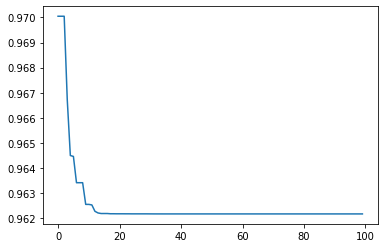

In [14]:
import matplotlib.pyplot as plt
plt.plot(pso.gbest_y_hist)
plt.show()

In [10]:
w1 = 0.21046787 
w2 = 0
w3 = 0.03355643
w4 = 0.32007481 
w5 = 0.1972246 
w6 = 0.14254287

In [11]:
v = w1 * leak_df['pred1'].values + w2 * leak_df['pred2'].values + w3 * leak_df['pred3'] +\
w4 * leak_df['pred4'].values + w5 * leak_df['pred5'].values + w6 * leak_df['pred6']
vl1p = np.log1p(v)
np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

0.9617519416036465

In [12]:
sample_submission = pd.read_csv(path + 'sample_submission.csv')

In [13]:
sample_submission['meter_reading'] = w1 * test_df.pred1 +  w2 * test_df.pred3  + w3 * test_df.pred2+\
      w4 * test_df.pred4+w5 * test_df.pred5+w6 * test_df.pred6
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

In [14]:
# Reindex the row_id, put the meter_reading into sample_submission
leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']

In [16]:
# Save the submission
sample_submission.to_csv('../../../Large_output/ensemble_pso_nn_first_9617.csv', index=False, float_format='%.4f')

In [ ]:
sample_submission.head()